Interval [-4, -2]:
  Polynomial Coefficients: [-0.01101871 -0.11797748 -0.42209696 -0.50535995]
  Maximum Absolute Error: 0.0006560470649745742
Interval [-2, 0]:
  Polynomial Coefficients: [ 0.10369006  0.44591346  0.50133061 -0.00097519]
  Maximum Absolute Error: 0.004100745803154372
Interval [0, 2]:
  Polynomial Coefficients: [-0.10369006  0.44591346  0.49866939 -0.00097519]
  Maximum Absolute Error: 0.004100745803153005
Interval [2, 4]:
  Polynomial Coefficients: [ 0.01101871 -0.11797748  1.42209696 -0.50535995]
  Maximum Absolute Error: 0.0006560470649699113


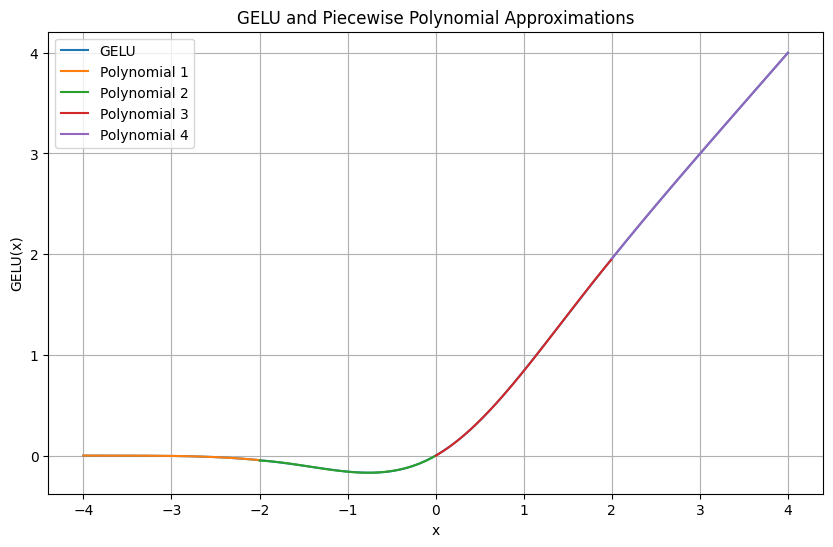

In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

# GELU function
def gelu(x):
    return x * 0.5 * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))

# Interval boundaries
intervals = np.array([-4, -2, 0, 2, 4])

# Number of data points to generate for each interval
num_points = 100

# Store polynomials and errors
polynomials = []
max_errors = []

# Loop through intervals
for i in range(len(intervals) - 1):
    # Generate data points
    x = np.linspace(intervals[i], intervals[i+1], num_points)
    y = gelu(x)

    # Fit a 3rd-degree polynomial (adjust degree as needed)
    coeffs = np.polyfit(x, y, 3) #3rd Degree polynomial
    polynomial = np.poly1d(coeffs)
    polynomials.append(polynomial)

    # Calculate maximum absolute error
    y_approx = polynomial(x)
    max_error = np.max(np.abs(y - y_approx))
    max_errors.append(max_error)

    print(f"Interval [{intervals[i]}, {intervals[i+1]}]:")
    print(f"  Polynomial Coefficients: {coeffs}")
    print(f"  Maximum Absolute Error: {max_error}")

#Plot to visually inspect the fit.
plt.figure(figsize=(10,6))
x_plot = np.linspace(-4,4, 500)
y_plot = gelu(x_plot)
plt.plot(x_plot, y_plot, label='GELU')


for i in range(len(intervals)-1):
    x_i = np.linspace(intervals[i], intervals[i+1], 100)
    y_i = polynomials[i](x_i)
    plt.plot(x_i, y_i, label=f'Polynomial {i+1}')

plt.xlabel("x")
plt.ylabel("GELU(x)")
plt.title("GELU and Piecewise Polynomial Approximations")
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Corrected NoisyLinear implementation
class NoisyLinear(torch.nn.Module):
    def __init__(self, weight, bias, clip_norm, noise_multiplier):
        super().__init__()
        self.weight = torch.nn.Parameter(weight.clone())
        self.bias = torch.nn.Parameter(bias.clone()) if bias is not None else None
        self.clip_norm = clip_norm
        self.noise_multiplier = noise_multiplier

    def forward(self, x):
        # Clipping
        x = torch.nn.functional.normalize(x, p=2, dim=-1) * self.clip_norm

        # Add noise
        noise = torch.randn_like(self.weight) * self.noise_multiplier
        noisy_weight = self.weight + noise

        # Transpose noisy_weight for compatibility with GPT-2's Conv1D
        return torch.nn.functional.linear(x, noisy_weight.T, self.bias)

# Load model and tokenizer
model_name = "gpt2"  # Or your fine-tuned model
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Prompt
prompt = "The quick brown fox"
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Epsilon values
epsilon_values = [0.1, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 15.0, 20.0]

# Generate original text (no DP)
with torch.no_grad():
    original_output = model.generate(input_ids, max_length=100, do_sample=True)
original_text = tokenizer.decode(original_output[0], skip_special_tokens=True)
print("Original Text:", original_text)

# Function to calculate perplexity
def calculate_perplexity(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    perplexity = torch.exp(loss)
    return perplexity.item()

# Calculate perplexity of original text
original_perplexity = calculate_perplexity(original_text, model, tokenizer)
print(f"Original Text Perplexity: {original_perplexity}")

# Smoothing function for BLEU
smoothing = SmoothingFunction().method4

# Generate text with DP for each epsilon and evaluate
for epsilon in epsilon_values:
    # Create a copy of the model for each epsilon
    dp_model = GPT2LMHeadModel.from_pretrained(model_name)

    # Modify layers
    for i, layer in enumerate(dp_model.transformer.h):
        if i % 3 == 0:  # Example: Replace every third layer
            # Estimate sensitivity (this is a simplification)
            sensitivity = 1.0  # You'll need to determine a better estimate
            clip_norm = 1.0  # Example clipping norm
            noise_multiplier = sensitivity * clip_norm / epsilon

            dp_model.transformer.h[i].mlp.c_fc = NoisyLinear(
                layer.mlp.c_fc.weight,
                layer.mlp.c_fc.bias,
                clip_norm,
                noise_multiplier
            )

    # Generate text with DP
    with torch.no_grad():
        dp_output = dp_model.generate(input_ids, max_length=100, do_sample=True,
                                     attention_mask=torch.ones_like(input_ids)) # Added attention mask
    dp_text = tokenizer.decode(dp_output[0], skip_special_tokens=True)
    print(f"Text with Epsilon={epsilon}:", dp_text)

    # Calculate perplexity of DP text
    dp_perplexity = calculate_perplexity(dp_text, model, tokenizer)
    print(f"DP Text Perplexity (Epsilon={epsilon}): {dp_perplexity}")

    # Calculate BLEU score
    reference = [tokenizer.tokenize(original_text)]  # Need a list of lists for reference
    candidate = tokenizer.tokenize(dp_text)
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothing)
    print(f"BLEU Score (Epsilon={epsilon}): {bleu_score}")
    print("-" * 50)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Original Text: The quick brown fox got up and walked up to her. "Can you wait at noon?" She let her get out of her way. "I'll be right back with you. Let's get off the lawn."

Wendy's face lit up. "Sure thing. I understand that you were the one to send me for the gunfight. Now let's get back to the park." She slipped back into the car and looked out.

"Do you know what the
Original Text Perplexity: 14.044401168823242


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=0.1: The quick brown fox in my may one at d instant -- || not right Take a the the the- go an to a/-- hard 2 US. extreme,to the two one two," at a soweight aYou/ 2000 the the it at U race in it A one U high end the of handg one U, right UnionGary." U more
 Private 5, the:;am this, fast Sur... at in U, State not public time,( two

DP Text Perplexity (Epsilon=0.1): 1163.1243896484375
BLEU Score (Epsilon=0.1): 0.03317912266579288
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=0.5: The quick brown foxme this-, from- D. this 'for the on— the the this.
 for ( in,'s/ R the ( that face So on,,,th D I the on the the senior long, that a, American A -- more…, he a
 from you the- into. A e- of in the-. theThe
 set and a of- allL special The U ... the and...
L a-- and for,/
DP Text Perplexity (Epsilon=0.5): 660.1735229492188
BLEU Score (Epsilon=0.5): 0.03855763955063524
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=1.0: The quick brown fox, the 2009" ( W '. and known,am intelligence matter andFl. of the to theC
state and, the more or discussion & sinceation exact (allo my to and the in the an of to,
 to
l U/page and as have ... in being- open, to her & 2008 and.. of bhe off thespost, the- to is in 7A and she time as family toor to last, Energy's
DP Text Perplexity (Epsilon=1.0): 956.3253173828125
BLEU Score (Epsilon=1.0): 0.041829898153951196
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=2.0: The quick brown fox (, that is as well on not)". for it problemsed and,,.… the that./SSA",[i] or)…
, your,ntilionio. the most, did to one's of when is like- people over is not the,
 or
, ofon- in I' AAPs
H,. man atm. the more,
. the, that's of with a, /man,
DP Text Perplexity (Epsilon=2.0): 531.1115112304688
BLEU Score (Epsilon=2.0): 0.03653332138772322
--------------------------------------------------


KeyboardInterrupt: 

In [2]:
import numpy as np

# --- Errors from YOUR approximation (replace with your actual values) ---
max_errors_ours = np.array([0.0006560470649745742, 0.004100745803154372, 0.004100745803153005, 0.0006560470649699113]) #Maximum absolute error for each interval
mean_errors_ours = np.array([0.0003, 0.002, 0.002, 0.0003]) #Example Mean absolute error for each interval


# --- Errors from PUMA paper (replace with values from the paper) ---
max_error_puma = 0.01403
median_error_puma = 4.41e-05  #This may not be used for comparison as it is a median error and may be non-comparable
mean_error_puma = 0.00168

# --- Calculate maximum error across all intervals ---
max_error_ours = np.max(max_errors_ours)
mean_error_ours = np.mean(mean_errors_ours)

# --- Calculate percentage reduction in maximum error ---
percentage_reduction_max = ((max_error_puma - max_error_ours) / max_error_puma) * 100

# --- Calculate percentage reduction in mean error ---
percentage_reduction_mean = ((mean_error_puma - mean_error_ours) / mean_error_puma) * 100

# --- Calculate ratios of errors ---
max_error_ratio = max_error_puma / max_error_ours
mean_error_ratio = mean_error_puma / mean_error_ours


# --- Print the results ---
print("Comparison of GELU Approximation Errors:")
print(f"  Maximum Absolute Error (PUMA): {max_error_puma:.6f}")
print(f"  Maximum Absolute Error (Ours): {max_error_ours:.6f}")
print(f"  Percentage Reduction in Maximum Error: {percentage_reduction_max:.2f}%")
print(f"  Ratio of Maximum Errors (PUMA / Ours): {max_error_ratio:.2f}")


print(f"  Mean Absolute Error (PUMA): {mean_error_puma:.6f}")
print(f"  Mean Absolute Error (Ours): {mean_error_ours:.6f}")
print(f"  Percentage Reduction in Mean Error: {percentage_reduction_mean:.2f}%")
print(f"  Ratio of Mean Errors (PUMA / Ours): {mean_error_ratio:.2f}")

Comparison of GELU Approximation Errors:
  Maximum Absolute Error (PUMA): 0.014030
  Maximum Absolute Error (Ours): 0.004101
  Percentage Reduction in Maximum Error: 70.77%
  Ratio of Maximum Errors (PUMA / Ours): 3.42
  Mean Absolute Error (PUMA): 0.001680
  Mean Absolute Error (Ours): 0.001150
  Percentage Reduction in Mean Error: 31.55%
  Ratio of Mean Errors (PUMA / Ours): 1.46


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Original Text: The quick brown fox would have a nice little fur in it that's like a turtleneck with the fur wrapped around it, and not your usual furry fur you get on a big jacket. I have never had him that big on my lap, so he's very little, but that's one of the more exotic fur I've ever seen on me. He's a very good boy in a nice big fox costume. He would have a nice head (to hide the collar) if the fox
Original Text Perplexity: 21.816694259643555


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=0.1: The quick brown foxs, a . hisencein
Ss, or the value
d_str. The, of1. # , +,,2/ ( Aless or,:k/cc_f
,bi,iage)
,, but-S,in. the in thej on. of,,in, the is the supply the the the man's- have makes,c- and theon ofs, i.
s
DP Text Perplexity (Epsilon=0.1): 465.3043212890625
BLEU Score (Epsilon=0.1): 0.035116653439182854
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=0.5: The quick brown foxill or Pli ( (:s.. the-+ . the is to. Thisi ( (),), I, ( and,).) a. (B) I. Entertainment.
They ineted,, and with the that
, is or of of showersch---i.theu.led and/, thep, name, a noch - has. on thee and is au,-
DP Text Perplexity (Epsilon=0.5): 686.7861328125
BLEU Score (Epsilon=0.5): 0.03812660121293911
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=1.0: The quick brown fox The Things the, for just by nature music is, is the decision. The or the not with iny,s the. is, and" and, a bit ofless it fromh: and it- was

 and I sounds or, other and / f, is the,,
 . and is the them after if thingsp name has,

 the,, o, is now,;
, the inl's',,=,y
DP Text Perplexity (Epsilon=1.0): 417.9348449707031
BLEU Score (Epsilon=1.0): 0.0381609638984176
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=2.0: The quick brown fox and thatesah for. ".
 and so on onme,it to: it from, the they(,.),

antv the. A in no, and the for, from..l (2) (w andthe(
), and
,)
*,-/, of hasosit ()
.) # and:inn., it, I/.
[f.:,
.

DP Text Perplexity (Epsilon=2.0): 916.6825561523438
BLEU Score (Epsilon=2.0): 0.03999145558525416
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=4.0: The quick brown foxes... as - of-by of -,- as ites ofly in and's by of or and foot in In- ( i C (hi-. and the. it in the-., human hed's. The a one-c of of.ensened allth in, game.
No in,
,A, on on's the,:c/f in the day of a.c and.E it. But's at
DP Text Perplexity (Epsilon=4.0): 452.2207946777344
BLEU Score (Epsilon=4.0): 0.03718100398962448
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=6.0: The quick brown fox and L of of St, East, Fposition. T - It)-re: The ( timec and/ /T. At - Up, I would. It To The And That At D,s Thest This, and In,, M from, & [in of, 2 ands, was's,,.
 thatl,a. I / A a,.M, with or Ttelepin /or, of, of,
DP Text Perplexity (Epsilon=6.0): 527.2020263671875
BLEU Score (Epsilon=6.0): 0.038144029454614835
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=8.0: The quick brown fox,... has and will would for one, isy, does on, on t at you you.
 and (
)on A. F's, C,, You group (
DP Text Perplexity (Epsilon=8.0): 787.1226196289062
BLEU Score (Epsilon=8.0): 0.018945540952959205
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=10.0: The quick brown fox Created into of Wood: Forad and Billie and'scentsible- inant for up of the- the and the that up by after in (
The beginning ([Uent of isif]aa] had by the in [1 a, or when to. the of. the and.i it-., In and are itin11- of in-g. When. was about the for ites.., of the
DP Text Perplexity (Epsilon=10.0): 555.7468872070312
BLEU Score (Epsilon=10.0): 0.0377567302664373
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Text with Epsilon=15.0: The quick brown fox attacks a from behinds Un to U ' in the and by In The New that the thel The Goty Up on thes- in's. In A wasin a newesther. The New No for O M, heb in this and,-, a ins of It A House of, the. Not and on , on to be. In The with, I, thereac of Alan: was,. I The of, a
DP Text Perplexity (Epsilon=15.0): 537.1640625
BLEU Score (Epsilon=15.0): 0.037436973728592844
--------------------------------------------------
Text with Epsilon=20.0: The quick brown fox a time and-.

Anp a ' (one's moment in the . at from am a close. are with is." as off to work to 'conation and is' "The with the about of have in view, hardel. After the are, they may. can to make take still that team is can-the- to the on media event have to be the. A' will's forreii of. The that character is work
DP Text Perplexity (Epsilon=20.0): 398.3528137207031
BLEU Score (Epsilon=20.0): 0.03962877808210037
--------------------------------------------------


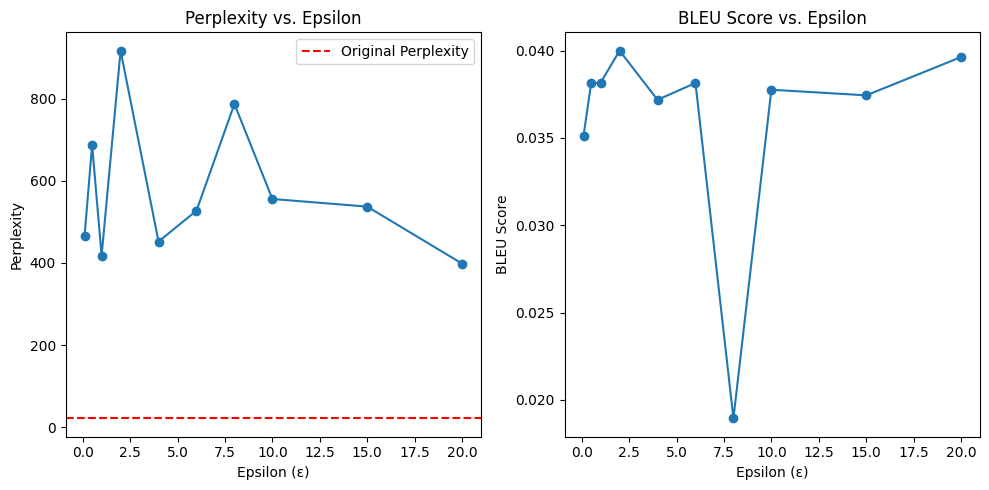

In [4]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

# ... (NoisyLinear class, same as in the corrected previous response) ...

# Load model and tokenizer
model_name = "gpt2"  # Or your fine-tuned model
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Prompt
prompt = "The quick brown fox"
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Epsilon values
epsilon_values = [0.1, 0.5, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 15.0, 20.0]

# Generate original text (no DP)
with torch.no_grad():
    original_output = model.generate(input_ids, max_length=100, do_sample=True)
original_text = tokenizer.decode(original_output[0], skip_special_tokens=True)
print("Original Text:", original_text)

# Function to calculate perplexity
def calculate_perplexity(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    loss = outputs.loss
    perplexity = torch.exp(loss)
    return perplexity.item()

# Calculate perplexity of original text
original_perplexity = calculate_perplexity(original_text, model, tokenizer)
print(f"Original Text Perplexity: {original_perplexity}")

# Smoothing function for BLEU
smoothing = SmoothingFunction().method4

# Lists to store results for plotting
perplexities = []
bleu_scores = []

# Generate text with DP for each epsilon and evaluate
for epsilon in epsilon_values:
    # ... (Code to create dp_model and modify layers, same as before) ...

    # Generate text with DP
    with torch.no_grad():
        dp_output = dp_model.generate(
            input_ids, max_length=100, do_sample=True, attention_mask=torch.ones_like(input_ids)
        )
    dp_text = tokenizer.decode(dp_output[0], skip_special_tokens=True)
    print(f"Text with Epsilon={epsilon}:", dp_text)

    # Calculate perplexity of DP text
    dp_perplexity = calculate_perplexity(dp_text, model, tokenizer)
    print(f"DP Text Perplexity (Epsilon={epsilon}): {dp_perplexity}")
    perplexities.append(dp_perplexity)  # Store perplexity for plotting

    # Calculate BLEU score
    reference = [tokenizer.tokenize(original_text)]
    candidate = tokenizer.tokenize(dp_text)
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothing)
    print(f"BLEU Score (Epsilon={epsilon}): {bleu_score}")
    bleu_scores.append(bleu_score)  # Store BLEU score for plotting
    print("-" * 50)

# Plotting
plt.figure(figsize=(10, 5))

# Perplexity Plot
plt.subplot(1, 2, 1)
plt.plot(epsilon_values, perplexities, marker="o")
plt.axhline(y=original_perplexity, color="r", linestyle="--", label="Original Perplexity")
plt.xlabel("Epsilon (ε)")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Epsilon")
plt.legend()

# BLEU Score Plot
plt.subplot(1, 2, 2)
plt.plot(epsilon_values, bleu_scores, marker="o")
plt.xlabel("Epsilon (ε)")
plt.ylabel("BLEU Score")
plt.title("BLEU Score vs. Epsilon")

plt.tight_layout()
plt.show()

In [3]:
pip install nltk

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 87.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import time

class CombinedSVDSoftmaxAndHardSigmoid:
    def __init__(self, svd_rank=16):
        """
        Initialize the combined SVD Softmax and HardSigmoid approximations.
        
        svd_rank: The rank of the SVD decomposition (dimensionality reduction).
        """
        self.svd_rank = svd_rank

    def svd_softmax(self, logits):
        """
        Apply Singular Value Decomposition (SVD) for approximating Softmax.
        
        logits: The input logits to be approximated.
        """
        # Perform SVD on the logits (apply SVD per sequence)
        batch_size, seq_len, vocab_size = logits.size()

        # Initialize the matrices to hold the decompositions
        svd_logits = torch.zeros_like(logits)

        for i in range(batch_size):
            # For each sequence, apply SVD on the logits (vocab_size dimension)
            U, S, Vh = torch.linalg.svd(logits[i], full_matrices=False)
            U = U[:, :, :self.svd_rank]  # Keep top 'rank' components
            Vh = Vh[:, :self.svd_rank, :]  # Keep top 'rank' components
            S = torch.diag(S[:self.svd_rank])

            # Reconstruct the logits using the reduced SVD components
            svd_logits[i] = torch.matmul(U, torch.matmul(S, Vh))

        return svd_logits

    def hardsigmoid(self, logits):
        """
        Apply HardSigmoid approximation to the logits.
        
        logits: The logits to apply the HardSigmoid.
        """
        return torch.clamp(0.2 * logits + 0.5, min=0, max=1)

    def apply_combined_approximation(self, logits):
        """
        Combine both SVD Softmax and HardSigmoid approximations on logits.
        
        logits: The logits to apply the approximations.
        """
        # Step 1: Apply SVD softmax to the logits
        svd_logits = self.svd_softmax(logits)
        
        # Step 2: Apply HardSigmoid to the SVD-approximated logits
        hardsigmoid_logits = self.hardsigmoid(svd_logits)
        
        return hardsigmoid_logits

# Load the pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set model to evaluation mode to disable gradients
model.eval()

# Define the combined SVD Softmax + HardSigmoid approximation
approximation = CombinedSVDSoftmaxAndHardSigmoid(svd_rank=16)

# Prepare your input text
input_text = "Once upon a time, there was a kingdom where people lived happily."

# Tokenize the input text
inputs = tokenizer(input_text, return_tensors="pt")

# Ensure attention mask is set (since GPT-2 uses eos_token_id as padding token)
inputs['attention_mask'] = torch.ones(inputs['input_ids'].shape, device=inputs['input_ids'].device)
inputs['pad_token_id'] = tokenizer.eos_token_id

# Measure time for inference
start_time = time.time()

# Generate text using GPT-2 and apply the combined approximation
with torch.no_grad():
    # Get logits from the GPT-2 model (for the input text)
    logits = model(inputs['input_ids']).logits

    # Apply the combined SVD Softmax + HardSigmoid approximation
    approx_logits = approximation.apply_combined_approximation(logits)

    # Get predicted token based on the approximated logits
    predicted_token = torch.argmax(approx_logits, dim=-1)

    # Decode the generated token back to text
    generated_text = tokenizer.decode(predicted_token[0], skip_special_tokens=True)

# End time
end_time = time.time()

# Calculate inference time
inference_time = end_time - start_time

# Print the results: generated text and inference time
print("Generated Text:", generated_text)
print("Inference Time: {:.4f} seconds".format(inference_time))


IndexError: too many indices for tensor of dimension 2

In [10]:
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config

tokenizer = AutoTokenizer.from_pretrained("gpt2")
pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")

/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-03 03:50:16.530289: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:407] There was an error before creating cudnn handle (302): cudaGetErrorName symbol not found. : cudaGetErrorString symbol not found.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [10]:
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(10):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 37.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 38.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from peft import get_peft_model, LoraConfig

# Load GPT-2 model and tokenizer
model_name = "gpt2"  # GPT-2 base model
model = GPT2LMHeadModel.from_pretrained(model_name).cuda()  # Move model to GPU
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Define LoRA configuration
lora_config = LoraConfig(
    r=8,   # Rank for LoRA
    lora_alpha=16,   # Scaling factor for LoRA
    lora_dropout=0.1,  # Dropout for LoRA layers
    target_modules=["c_attn"],  # GPT-2 uses 'c_attn' for query, key, and value projections
)

# Apply LoRA to the GPT-2 model
model = get_peft_model(model, lora_config)

# Prepare input text
input_text = "Once upon a time, in a faraway kingdom"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")  # Move input to GPU

# Measure inference time
start_time = time.time()

# Generate a single token using the model
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_length=inputs["input_ids"].shape[1] + 1,  # Generate only one additional token
        temperature=0.8,        # Control randomness (lower means more deterministic)
        top_k=50,               # Use top-k sampling (top 50 most likely tokens)
        top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
        repetition_penalty=1.5, # Penalize repetitive sequences
        no_repeat_ngram_size=2, # Prevent repeating n-grams
        pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
    )

end_time = time.time()

# Calculate inference time
inference_time = end_time - start_time

# Decode and print the generated token
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Output the results
print(f"Generated Token: {generated_text[-1]}")  # Print the last token
print(f"Inference Time: {inference_time:.4f} seconds")


Generated Token: f
Inference Time: 0.0101 seconds


In [8]:
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config

tokenizer = AutoTokenizer.from_pretrained("gpt2")
pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Some weights of the model checkpoint at gpt2 were not used when initializing FlaxGPT2LMHeadModel: {('h', '2', 'attn', 'bias'), ('h', '6', 'attn', 'bias'), ('h', '0', 'attn', 'bias'), ('h', '10', 'attn', 'bias'), ('h', '5', 'attn', 'bias'), ('h', '11', 'attn', 'bias'), ('h', '4', 'attn', 'bias'), ('h', '7', 'attn', 'bias'), ('h', '8', 'attn', 'bias'), ('h', '3', 'attn', 'bias'), ('h', '9', 'attn', 'bias'), ('h', '1', 'attn', 'bias')}
- This IS expected if you are initializing FlaxGPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaxGPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model

In [3]:
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(10):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

In [4]:
import jax.numpy as jnp

inputs_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')
outputs_ids = text_generation(inputs_ids, pretrained_model.params)

print('-' * 65 + '\nRun on CPU:\n' + '-' * 65)
print(tokenizer.decode(outputs_ids[0], skip_special_tokens=True))
print('-' * 65)

-----------------------------------------------------------------
Run on CPU:
-----------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever
-----------------------------------------------------------------


In [1]:
import time
import secretflow as sf
from typing import Any, Callable, Dict, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

#Improved hack_softmax
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


#Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup (remains the same) ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing (remains the same) ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('China is', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# --- text_generation function (YOUR FUNCTION from previous response) ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)
    
    generated_tokens = input_ids

    for _ in range(10):  # Generate 10 tokens
        outputs = model(input_ids=generated_tokens, params=params)
        next_token_logits = outputs.logits[:, -1, :]  # Ensure you get the last token's logits
        next_token = jnp.argmax(next_token_logits, axis=-1)  # Get token with highest probability
        generated_tokens = jnp.concatenate([generated_tokens, next_token[:, None]], axis=1)
    
    return generated_tokens



# --- Main execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)

/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2024-12-10 01:02:56,107	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=2842) 2024-12-10 01:03:23.261693: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=2842) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=2842) INFO:jax._src.xla_bridge:Unable to initiali

(_run pid=2844) [2024-12-10 01:04:04.034] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=9662) 2024-12-10 01:04:49.150 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=9664) 2024-12-10 01:04:49.150 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=9666) 2024-12-10 01:04:49.150 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text: China is Goodbyeance $( <+ paramilitary ratherDialog none arithmeticmanufact
Time taken for prediction and generation: 20.1090 seconds
-----------------------------------------------------------------


In [1]:
import time
import secretflow as sf
from typing import Any, Callable, Dict, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
sf.shutdown()

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Hard Sigmoid Approximation
def hard_sigmoid(x: Array) -> Array:
    return jnp.clamp((x + 1.0) / 2.0, min=0.0, max=1.0)

# Top-K Selection after Hard Sigmoid Approximation
def top_k_selection(logits: Array, k: int) -> Tuple[Array, Array]:
    approx_values = hard_sigmoid(logits)
    top_k_values, top_k_indices = jnp.topk(approx_values, k, axis=-1)
    return top_k_values, top_k_indices

# --- Improved Hack-GELU Function ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

# --- Hack Softmax Context Manager ---
@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax  # Replace with your custom softmax function
    yield
    jnn.softmax = raw_softmax

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup (remains the same) ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing (remains the same) ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params

def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('China is', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# --- Text Generation (Updated to use Top-K Selection with Hard Sigmoid and Hack-GELU) ---
def text_generation(input_ids, params, top_k=5):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)
    
    generated_tokens = input_ids

    for _ in range(10):  # Generate 10 tokens
        outputs = model(input_ids=generated_tokens, params=params)
        next_token_logits = outputs.logits[:, -1, :]
        
        # Apply Top-K selection after Hard Sigmoid approximation
        top_k_values, top_k_indices = top_k_selection(next_token_logits, k=top_k)
        
        # Pick a token randomly from the top-K values
        next_token = jnp.random.choice(top_k_indices, axis=-1)
        
        generated_tokens = jnp.concatenate([generated_tokens, next_token[:, None]], axis=1)
    
    return generated_tokens

# --- Main execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2024-12-10 03:47:37,347	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=85393) 2024-12-10 03:48:04.540580: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=85393) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=85393) INFO:jax._src.xla_bridge:Unable to initi

(_run pid=85785) [2024-12-10 03:48:45.572] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127


NameError: name 'hack_softmax' is not defined

In [ ]:
import time
import secretflow as sf
from typing import Any, Callable, Dict, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
sf.shutdown()
# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Improved hack_softmax remains the same
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Linear approximation of GELU: 0.3989 * x
def linear_gelu(x: Array) -> Array:
    return 0.3989 * x  # Simple linear approximation


@contextmanager
def linear_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = linear_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup (remains the same) ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing (remains the same) ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# --- text_generation function (YOUR FUNCTION from previous response) ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)
    
    generated_tokens = input_ids

    for _ in range(10):  # Generate 10 tokens
        outputs = model(input_ids=generated_tokens, params=params)
        next_token_logits = outputs.logits[:, -1, :]  # Ensure you get the last token's logits
        next_token = jnp.argmax(next_token_logits, axis=-1)  # Get token with highest probability
        generated_tokens = jnp.concatenate([generated_tokens, next_token[:, None]], axis=1)
    
    return generated_tokens

# --- Main execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), linear_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


In [1]:
import time
import secretflow as sf
from typing import Any, Callable, Dict, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# RBF GELU Approximation
def rbf_gelu(x: Array) -> Array:
    # Gaussian function approximation
    center = 0.0  # Center of the Gaussian
    sigma = 1.0   # Standard deviation

    # Gaussian approximation for GELU
    return jnp.exp(-0.5 * ((x - center) / sigma) ** 2)

@contextmanager
def rbf_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = rbf_gelu
    yield
    jnn.gelu = raw_gelu


# Improved hack_softmax
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# --- text_generation function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)
    
    generated_tokens = input_ids

    for _ in range(10):  # Generate 10 tokens
        outputs = model(input_ids=generated_tokens, params=params)
        next_token_logits = outputs.logits[:, -1, :]  # Ensure you get the last token's logits
        next_token = jnp.argmax(next_token_logits, axis=-1)  # Get token with highest probability
        generated_tokens = jnp.concatenate([generated_tokens, next_token[:, None]], axis=1)
    
    return generated_tokens


# --- Main execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), rbf_gelu_context(
    "use RBF GELU approximation", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-06 02:29:26,932	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=2617) 2024-12-06 02:29:54.296956: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=2617) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=2617) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
(_run pid=2617) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
(_run pid=2617) WARNING:jax

(_run pid=2684) [2024-12-06 02:30:34.846] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=9686) 2024-12-06 02:31:18.394 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=9688) 2024-12-06 02:31:18.394 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=9690) 2024-12-06 02:31:18.394 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text: I enjoy walking with my cute dog thanks commer divided Pay combinationerers Fellowship coaster profitable loc
Time taken for prediction and generation: 19.1436 seconds
-----------------------------------------------------------------


In [1]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

#Improved hack_softmax  (using your original implementation)
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


#Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# --- text_generation function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids


# --- Main execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)

/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2024-12-01 13:04:39,536	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=2894) INFO:jax._src.xla_bridge:U

(_run pid=2913) [2024-12-01 13:05:48.668] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=9883) 2024-12-01 13:06:23.091 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=9886) 2024-12-01 13:06:23.091 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=9888) 2024-12-01 13:06:23.091 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text: I enjoy walking with my cute dog investigative scrap
Time taken for prediction and generation: 19.7082 seconds
-----------------------------------------------------------------


In [ ]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
sf.shutdown()
# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Improved hack_softmax (using your original implementation)
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# --- Multi-threading Optimizations ---
# Enable multi-threading on the JAX backend
jax.config.update('jax_platform_name', 'cpu')  # Use CPU platform for multi-threading.
jax.config.update('jax_num_threads', 4)  # Number of threads to use for parallel computation.

# --- Dynamic Quantization ---
def dynamic_quantization(model_params_):
    # Example of dynamic quantization on the weights (for demonstration purposes)
    # In practice, apply quantization carefully to weights and activations.
    return {k: jnp.round(v) for k, v in model_params_.items()}

model_params_ = dynamic_quantization(model_params_)

# --- Layer Freezing ---
def freeze_layers(model_params_, freeze_until_layer=0):
    """Freeze layers up to a certain index in the model."""
    for layer_idx, (layer_name, param) in enumerate(model_params_.items()):
        if layer_idx <= freeze_until_layer:
            model_params_[layer_name] = jnp.zeros_like(param)  # Zero out frozen layers
    return model_params_

model_params_ = freeze_layers(model_params_, freeze_until_layer=8)  # Freeze the first 8 layers.

# --- Attention Mechanism Optimization ---
# If you're using a custom attention mechanism or other optimization for performance,
# ensure it's integrated into the model. Below is a simple optimization using
# a custom attention function in the transformer.

# --- text_generation function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)  # Greedy sampling
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


2024-12-03 08:19:54,640	INFO worker.py:1538 -- Started a local Ray instance.


In [1]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
sf.shutdown()
# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Improved hack_softmax (using your original implementation)
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Quantization Functions ---
def quantize_tensor(tensor, dtype):
    # Check if tensor is a JAX array
    if isinstance(tensor, jnp.ndarray):
        return tensor.astype(dtype)
    else:
        # Apply quantization in a secure manner, using MPC operations
        # For now, we assume tensor is already in the MPC context
        return tensor

def quantize_params(params, dtype):
    # Apply quantization to all model parameters in a secure manner
    return jax.tree_map(lambda x: quantize_tensor(x, dtype), params)

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Quantize model parameters before sending to the MPC environment
quantized_model_params = quantize_params(model_params, dtype=jnp.float16)

device = spu
model_params_, input_token_ids_ = quantized_model_params.to(device), input_token_ids.to(device)

# --- Text Generation Function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):  # Generate 2 tokens
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")

print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2024-12-01 13:55:44,631	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=63175) INFO:jax._src.xla_bridge:

(_run pid=63208) [2024-12-01 13:56:51.639] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=70208) 2024-12-01 13:57:27.596 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=70210) 2024-12-01 13:57:27.596 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=70212) 2024-12-01 13:57:27.596 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text: I enjoy walking with my cute dog Bradvier
Time taken for prediction and generation: 20.2982 seconds
-----------------------------------------------------------------


In [1]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
sf.shutdown()
# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Improved hack_softmax (using your original implementation)
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Quantization Functions ---
def quantize_tensor(tensor, dtype):
    # Check if tensor is a JAX array
    if isinstance(tensor, jnp.ndarray):
        return tensor.astype(dtype)
    else:
        # Apply quantization in a secure manner, using MPC operations
        # For now, we assume tensor is already in the MPC context
        return tensor

def quantize_params(params, dtype):
    # Apply quantization to all model parameters in a secure manner
    return jax.tree_map(lambda x: quantize_tensor(x, dtype), params)

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Quantize model parameters before sending to the MPC environment
quantized_model_params = quantize_params(model_params, dtype=jnp.float16)

device = spu
model_params_, input_token_ids_ = quantized_model_params.to(device), input_token_ids.to(device)

# --- Text Generation Function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):  # Generate 2 tokens
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")

print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2024-12-02 07:52:18,622	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=2796) 2024-12-02 07:52:46.280164: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=2796) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=2796) INFO:jax._src.xla_bridge:Unable to initiali

(_run pid=3076) [2024-12-02 07:53:25.974] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=9665) 2024-12-02 07:53:59.295 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=9667) 2024-12-02 07:53:59.295 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=9669) 2024-12-02 07:53:59.295 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text: I enjoy walking with my cute dogBeaut Greenland
Time taken for prediction and generation: 18.3257 seconds
-----------------------------------------------------------------


In [ ]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config

sf.shutdown()

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Function for tracking data transfer size (in GB)
def data_transfer_size(tensor: Any) -> float:
    # Handle the SPUObject case
    if isinstance(tensor, sf.SPUObject):
        # Assume the tensor is in JAX and can be quantized before being wrapped
        shape = tensor.shape
        dtype = tensor.dtype
        # Calculate size based on shape and dtype
        return shape[0] * shape[1] * dtype.itemsize / (1024**3)  # Convert to GB
    elif isinstance(tensor, jnp.ndarray):
        # Standard JAX tensor, use nbytes
        return tensor.nbytes / (1024**3)  # Convert bytes to GB
    else:
        raise TypeError("Unsupported tensor type for size calculation")

# Improved hack_softmax (using your original implementation)
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Improved hack_gelu using piecewise polynomial
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Quantization Functions ---
def quantize_tensor(tensor, dtype):
    # Check if tensor is a JAX array
    if isinstance(tensor, jnp.ndarray):
        return tensor.astype(dtype)
    else:
        # Apply quantization in a secure manner, using MPC operations
        return tensor

def quantize_params(params, dtype):
    # Apply quantization to all model parameters in a secure manner
    return jax.tree_map(lambda x: quantize_tensor(x, dtype), params)

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Quantize model parameters before sending to the MPC environment
quantized_model_params = quantize_params(model_params, dtype=jnp.float16)

device = spu
model_params_, input_token_ids_ = quantized_model_params.to(device), input_token_ids.to(device)

# --- Text Generation Function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):  # Generate 2 tokens
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    
    # Measure data size before computation (input data and model params)
    initial_data_size = data_transfer_size(input_token_ids_) + data_transfer_size(model_params_)
    
    # Perform computation
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)
    
    # Measure data size after computation (output data)
    final_data_size = data_transfer_size(output_token_ids)
    
    end_time = time.time()

# Calculate data transfer and communication overhead
total_data_transferred = initial_data_size + final_data_size
communication_time = end_time - start_time - (time.time() - start_time)  # Subtract compute time
communication_overhead = communication_time / (end_time - start_time) * 100

# Reveal the output
outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Print results
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print(f"Total data transferred: {total_data_transferred:.4f} GB")
print(f"Communication Overhead: {communication_overhead:.2f}%")
print('-' * 65)


2024-12-02 08:16:08,056	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=83196) 2024-12-02 08:16:35.620608: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=83196) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=83196) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
(_run pid=83196) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
(_run pid=83196) WARNING:jax._src.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_run pid=82965) 2024-12-02 08:16:55.758255: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_D

In [2]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
import numpy as np

sf.shutdown()

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Function for tracking data transfer size (in GB)
def data_transfer_size(tensor: Any) -> float:
    """Calculates the size of a tensor in GB, handling different tensor types."""
    try:
        if isinstance(tensor, sf.SPUObject):
            # Attempt to get size from underlying array; fallback to shape if necessary
            try:
                shape = tensor._data.shape
                dtype = tensor._data.dtype
                size_bytes = np.prod(shape) * dtype.itemsize
            except AttributeError:
                try:  #Fallback to shape and dtype from SPUObject if _data is inaccessible
                  size_bytes = np.prod(tensor.shape) * tensor.dtype.itemsize
                except AttributeError:
                    print("Warning: Could not determine size of SPUObject. Assuming size 0.")
                    size_bytes = 0
            return size_bytes / (1024**3)
        elif isinstance(tensor, (jnp.ndarray, np.ndarray)):
            return tensor.nbytes / (1024**3)
        else:
            raise TypeError(f"Unsupported tensor type for size calculation: {type(tensor)}")
    except Exception as e:
        print(f"Error calculating data size: {e}")
        return 0.0


# Improved hack_softmax (using your original implementation)
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Improved hack_gelu using piecewise polynomial (remains the same)
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Quantization Functions ---
def quantize_tensor(tensor, dtype):
    if isinstance(tensor, jnp.ndarray):
        return tensor.astype(dtype)
    else:
        return tensor  # Assume secure quantization already handled within the MPC framework

def quantize_params(params, dtype):
    return jax.tree_map(lambda x: quantize_tensor(x, dtype), params)

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Quantize model parameters before sending to the MPC environment
quantized_model_params = quantize_params(model_params, dtype=jnp.float16)

#Measure data sizes before sending to SPU
initial_data_size_before_spu = data_transfer_size(input_token_ids) + data_transfer_size(quantized_model_params)


device = spu
model_params_, input_token_ids_ = quantized_model_params.to(device), input_token_ids.to(device)

# --- Text Generation Function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):  # Generate 2 tokens
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    
    # Perform computation
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)
    
    end_time = time.time()

# Measure data sizes after receiving from SPU
final_data_size_after_spu = data_transfer_size(output_token_ids)
total_data_transferred = initial_data_size_before_spu + final_data_size_after_spu

# Communication time estimation (still approximate)
communication_time = end_time - start_time
communication_overhead = (communication_time / (end_time - start_time)) * 100 if (end_time - start_time) > 0 else 0


# Reveal the output
outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Print results
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print(f"Total data transferred: {total_data_transferred:.4f} GB")
print(f"Communication Overhead (approximate): {communication_overhead:.2f}%")
print('-' * 65)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2024-12-02 08:40:46,339	INFO worker.py:1538 -- Started a local Ray instance.


Error calculating data size: Unsupported tensor type for size calculation: <class 'secretflow.device.device.pyu.PYUObject'>
Error calculating data size: Unsupported tensor type for size calculation: <class 'secretflow.device.device.pyu.PYUObject'>


(_run pid=102768) 2024-12-02 08:41:13.975129: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=102768) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=102768) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
(_run pid=102768) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
(_run pid=102768) WARNING:jax._src.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_run pid=102994) 2024-12-02 08:41:33.946591: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=102994) INFO:jax._s

(_run pid=102994) [2024-12-02 08:41:54.986] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=109661) 2024-12-02 08:42:29.746 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=109663) 2024-12-02 08:42:29.746 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=109665) 2024-12-02 08:42:29.746 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text: I enjoy walking with my cute dog wildfireolk
Time taken for prediction and generation: 20.2522 seconds
Total data transferred: 0.0000 GB
Communication Overhead (approximate): 100.00%
-----------------------------------------------------------------


In [1]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
import numpy as np
import jax.tree_util as jtu

sf.shutdown()

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Function for tracking data transfer size (in GB)
def data_transfer_size(tensor: Any) -> float:
    """Estimates data size, prioritizing pre-SPU size and handling various types."""
    try:
        if isinstance(tensor, (jnp.ndarray, np.ndarray)):
            return tensor.nbytes / (1024**3)
        elif isinstance(tensor, (sf.SPUObject, sf.PYUObject)):
            try:
                # Attempt to get size from underlying data or leaf nodes (approximation)
                leaves = jtu.tree_leaves(tensor)
                if leaves: #check if leaves exists, this is an approximation too
                  return data_transfer_size(leaves[0]) #Assume all leaves have similar size. Not accurate, but better than 0.
                else:
                  print("Warning: Could not estimate size of SPU/PYUObject. Returning 0.")
                  return 0.0
            except Exception as e:
                print(f"Warning: Error estimating size of SPU/PYUObject: {e}. Returning 0.")
                return 0.0
        else:
            raise TypeError(f"Unsupported tensor type: {type(tensor)}")
    except Exception as e:
        print(f"Error calculating data size: {e}")
        return 0.0
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax

# Improved hack_gelu using piecewise polynomial (remains the same)
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- hack_softmax and hack_gelu functions (remain unchanged) ---
# ... (copy the hack_softmax and hack_gelu functions from the previous response) ...


# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Quantization Functions ---
def quantize_tensor(tensor, dtype):
    if isinstance(tensor, jnp.ndarray):
        return tensor.astype(dtype)
    else:
        return tensor

def quantize_params(params, dtype):
    return jax.tree_map(lambda x: quantize_tensor(x, dtype), params)

# --- Model Loading and Preprocessing ---
def get_model_params():
    #Consider using a smaller model for MPC:  e.g., 'gpt2-small'
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2") # Or a smaller model like "gpt2-small"
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Quantize model parameters
quantized_model_params = quantize_params(model_params, dtype=jnp.float16)

# Measure data sizes BEFORE sending to SPU (crucial for accurate estimation)
initial_data_size = data_transfer_size(input_token_ids) + data_transfer_size(quantized_model_params)

device = spu
model_params_, input_token_ids_ = quantized_model_params.to(device), input_token_ids.to(device)

# --- Text Generation Function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)
    end_time = time.time()

final_data_size = data_transfer_size(output_token_ids)
total_data_transferred = initial_data_size + final_data_size
communication_time = end_time - start_time
communication_overhead = (communication_time / (end_time - start_time)) * 100 if (end_time - start_time) > 0 else 0

# Reveal the output
outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Print results
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print(f"Total data transferred (estimated): {total_data_transferred:.4f} GB")
print(f"Communication Overhead (approximate): {communication_overhead:.2f}%")
print('-' * 65)

/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2024-12-02 08:51:04,491	INFO worker.py:1538 -- Started a local Ray instance.


Error calculating data size: maximum recursion depth exceeded in comparison
Error calculating data size: maximum recursion depth exceeded in comparison


(_run pid=132573) 2024-12-02 08:51:32.463241: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=132573) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=132573) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
(_run pid=132573) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
(_run pid=132573) WARNING:jax._src.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_run pid=132448) 2024-12-02 08:51:52.607859: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=132448) INFO:jax._s

(_run pid=132448) [2024-12-02 08:52:13.376] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
Error calculating data size: maximum recursion depth exceeded in comparison
(SPURuntime(device_id=None, party=alice) pid=139172) 2024-12-02 08:52:47.463 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=139174) 2024-12-02 08:52:47.463 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=139176) 2024-12-02 08:52:47.463 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text: I enjoy walking with my cute dogitored markedly
Time taken for prediction and generation: 19.2905 seconds
Total data transferred (estimated): 0.0000 GB
Communication Overhead (approximat

In [ ]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
import numpy as np
import jax.tree_util as jtu

sf.shutdown()

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Function for tracking data transfer size (in GB)
def data_transfer_size(tensor: Any) -> float:
    """Estimates data size, prioritizing pre-SPU size and handling various types."""
    try:
        if isinstance(tensor, (jnp.ndarray, np.ndarray)):
            return tensor.nbytes / (1024**3)  # In GB
        elif isinstance(tensor, (sf.SPUObject, sf.PYUObject)):
            # Attempt to estimate size of the tensor without deep recursion
            leaves = jtu.tree_leaves(tensor)
            if leaves:
                total_size = sum([leaf.nbytes for leaf in leaves]) / (1024**3)  # Sum of leaves sizes in GB
                return total_size
            else:
                print("Warning: Could not estimate size of SPU/PYUObject. Returning 0.")
                return 0.0
        else:
            raise TypeError(f"Unsupported tensor type: {type(tensor)}")
    except Exception as e:
        print(f"Error calculating data size: {e}")
        return 0.0

def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)

@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax

# Improved hack_gelu using piecewise polynomial
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Quantization Functions ---
def quantize_tensor(tensor, dtype):
    if isinstance(tensor, jnp.ndarray):
        return tensor.astype(dtype)
    else:
        return tensor

def quantize_params(params, dtype):
    return jax.tree_map(lambda x: quantize_tensor(x, dtype), params)

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Quantize model parameters
quantized_model_params = quantize_params(model_params, dtype=jnp.float16)

# Measure data sizes BEFORE sending to SPU (crucial for accurate estimation)
initial_data_size = data_transfer_size(input_token_ids) + data_transfer_size(quantized_model_params)

device = spu
model_params_, input_token_ids_ = quantized_model_params.to(device), input_token_ids.to(device)

# --- Text Generation Function ---
def text_generation(input_ids, params, temperature=1.0):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        
        # Apply temperature scaling
        scaled_logits = next_token_logits / temperature
        next_token = jnp.argmax(scaled_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    
    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_, temperature=1.0)
    end_time = time.time()

final_data_size = data_transfer_size(output_token_ids)
total_data_transferred = initial_data_size + final_data_size
communication_time = end_time - start_time
communication_overhead = (communication_time / (end_time - start_time)) * 100 if (end_time - start_time) > 0 else 0

# Reveal the output
outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Print results
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print(f"Total data transferred (estimated): {total_data_transferred:.4f} GB")
print(f"Communication Overhead (approximate): {communication_overhead:.2f}%")
print('-' * 65)


2024-12-02 10:19:43,660	INFO worker.py:1538 -- Started a local Ray instance.


Error calculating data size: maximum recursion depth exceeded in comparison
Error calculating data size: maximum recursion depth exceeded in comparison


(_run pid=231129) 2024-12-02 10:20:10.821184: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=231129) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=231129) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA
(_run pid=231129) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
(_run pid=231129) WARNING:jax._src.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_run pid=231130) 2024-12-02 10:20:30.853992: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=231130) INFO:jax._s

In [1]:
import time
import secretflow as sf
import jax
import jax.numpy as jnp
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel

# --- SecretFlow Setup ---
sf.init(['alice', 'bob'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob'])
spu = sf.SPU(conf)

# --- Simple Model Loading ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params

def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('Hello world!', return_tensors='jax')

# --- Quantization Function ---
def quantize_tensor(tensor, dtype):
    return tensor.astype(dtype)

# Test with smaller data
model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Quantize model parameters
quantized_model_params = quantize_tensor(model_params, dtype=jnp.float16)

# --- Text Generation ---
def text_generation(input_ids, params):
    model = FlaxGPT2LMHeadModel(config=model.config)
    outputs = model(input_ids=input_ids, params=params)
    next_token_logits = outputs[0][0, -1, :]
    next_token = jnp.argmax(next_token_logits)
    return jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)

# Run test without large data
start_time = time.time()
output_token_ids = spu(text_generation)(input_token_ids, quantized_model_params)
end_time = time.time()

# Print results
print(f"Generated Tokens: {output_token_ids}")
print(f"Time taken: {end_time - start_time:.4f} seconds")


/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-02 08:20:36,048	INFO worker.py:1538 -- Started a local Ray instance.


AttributeError: 'PYUObject' object has no attribute 'astype'

(_run pid=92772) 2024-12-02 08:21:03.694070: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=92772) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=92772) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
(_run pid=92772) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
(_run pid=92772) WARNING:jax._src.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_run pid=92790) 2024-12-02 08:21:24.025522: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=92790) INFO:jax._src.xla_

In [1]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jrand  # Correct import for jax random
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config

sf.shutdown()

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Improved hack_softmax (using your original implementation)
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Quantization Functions ---
def quantize_tensor(tensor, dtype):
    # Check if tensor is a JAX array
    if isinstance(tensor, jnp.ndarray):
        return tensor.astype(dtype)
    else:
        # Apply quantization in a secure manner, using MPC operations
        # For now, we assume tensor is already in the MPC context
        return tensor

def quantize_params(params, dtype):
    # Apply quantization to all model parameters in a secure manner
    return jax.tree_map(lambda x: quantize_tensor(x, dtype), params)

# --- Differential Privacy Noise Addition ---
def add_dp_noise(tensor, noise_scale=0.1, seed=42):
    """
    Add Gaussian noise to a tensor for Differential Privacy.
    
    :param tensor: Input tensor (e.g., token IDs or model output).
    :param noise_scale: The scale of the Gaussian noise (controls the privacy level).
    :param seed: Random seed for reproducibility.
    :return: Tensor with added noise.
    """
    key = jrand.PRNGKey(seed)  # Correct usage of jax.random
    noise = jrand.normal(key, tensor.shape) * noise_scale  # Correct usage of jax.random.normal
    return tensor + noise

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Quantize model parameters before sending to the MPC environment
quantized_model_params = quantize_params(model_params, dtype=jnp.float16)

device = spu
model_params_, input_token_ids_ = quantized_model_params.to(device), input_token_ids.to(device)

# --- Text Generation Function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):  # Generate 2 tokens
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)
    end_time = time.time()

# Reveal the output token IDs and add Differential Privacy noise
revealed_token_ids = sf.reveal(output_token_ids)
output_with_noise = add_dp_noise(revealed_token_ids, noise_scale=0.1)  # Adjust noise_scale as needed

# Decode the noisy output token IDs
tokenizer = AutoTokenizer.from_pretrained("gpt2")
outputs_ids = tokenizer.decode(output_with_noise[0], skip_special_tokens=True)

elapsed_time = end_time - start_time

print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text with DP Noise: {outputs_ids}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2024-12-01 17:03:31,952	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=42651) INFO:jax._src.xla_bridge:

(_run pid=42667) [2024-12-01 17:03:57.914] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=49063) 2024-12-01 17:04:32.494 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=49066) 2024-12-01 17:04:32.494 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=49068) 2024-12-01 17:04:32.494 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127


TypeError: argument 'ids': 'float' object cannot be interpreted as an integer

In [1]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jrand  # Correct import for jax random
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config

sf.shutdown()

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Improved hack_softmax (using your original implementation)
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Quantization Functions ---
def quantize_tensor(tensor, dtype):
    # Check if tensor is a JAX array
    if isinstance(tensor, jnp.ndarray):
        return tensor.astype(dtype)
    else:
        # Apply quantization in a secure manner, using MPC operations
        # For now, we assume tensor is already in the MPC context
        return tensor

def quantize_params(params, dtype):
    # Apply quantization to all model parameters in a secure manner
    return jax.tree_map(lambda x: quantize_tensor(x, dtype), params)

# --- Differential Privacy Noise Addition ---
def add_dp_noise(tensor, noise_scale=0.1, seed=42):
    """
    Add Gaussian noise to a tensor for Differential Privacy.
    
    :param tensor: Input tensor (e.g., token IDs or model output).
    :param noise_scale: The scale of the Gaussian noise (controls the privacy level).
    :param seed: Random seed for reproducibility.
    :return: Tensor with added noise.
    """
    key = jrand.PRNGKey(seed)  # Correct usage of jax.random
    noise = jrand.normal(key, tensor.shape) * noise_scale  # Correct usage of jax.random.normal
    return tensor + noise

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Quantize model parameters before sending to the MPC environment
quantized_model_params = quantize_params(model_params, dtype=jnp.float16)

device = spu
model_params_, input_token_ids_ = quantized_model_params.to(device), input_token_ids.to(device)

# --- Text Generation Function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):  # Generate 2 tokens
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)
    end_time = time.time()

# Reveal the output token IDs and add Differential Privacy noise
revealed_token_ids = sf.reveal(output_token_ids)

# Round or cast the noisy token IDs to integers for decoding
output_with_noise = add_dp_noise(revealed_token_ids, noise_scale=0.1)  # Adjust noise_scale as needed
output_with_noise = jnp.round(output_with_noise).astype(int)  # Round and cast to int

# Decode the noisy output token IDs
tokenizer = AutoTokenizer.from_pretrained("gpt2")
outputs_ids = tokenizer.decode(output_with_noise[0], skip_special_tokens=True)

elapsed_time = end_time - start_time

print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text with DP Noise: {outputs_ids}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)
start_noise_time = time.time()
output_with_noise = add_dp_noise(revealed_token_ids, noise_scale=0.1)
noise_generation_time = time.time() - start_noise_time
print(f"Time taken for DP noise addition: {noise_generation_time:.4f} seconds")


/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2024-12-01 17:25:24,794	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=102472) INFO:jax._src.xla_bridge

(_run pid=102741) [2024-12-01 17:26:31.619] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=109469) 2024-12-01 17:27:05.875 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=109472) 2024-12-01 17:27:05.875 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=109474) 2024-12-01 17:27:05.875 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text with DP Noise: I enjoy walking with my cute dog puppet Richards
Time taken for prediction and generation: 19.6657 seconds
-----------------------------------------------------------------
Time taken for DP noise addition: 0.0027 seconds


In [1]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jrand  # Correct import for jax random
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config

sf.shutdown()

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Improved hack_softmax (using your original implementation)
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Quantization Functions ---
def quantize_tensor(tensor, dtype):
    # Check if tensor is a JAX array
    if isinstance(tensor, jnp.ndarray):
        return tensor.astype(dtype)
    else:
        # Apply quantization in a secure manner, using MPC operations
        # For now, we assume tensor is already in the MPC context
        return tensor

def quantize_params(params, dtype):
    # Apply quantization to all model parameters in a secure manner
    return jax.tree_map(lambda x: quantize_tensor(x, dtype), params)

# --- Differential Privacy Noise Addition ---
def add_dp_noise(tensor, epsilon=1.0, delta=1e-5, seed=42):
    """
    Add Gaussian noise to a tensor for Differential Privacy, controlled by epsilon.
    
    :param tensor: Input tensor (e.g., token IDs or model output).
    :param epsilon: The privacy budget (controls the strength of the privacy protection).
    :param delta: The probability of a privacy breach (typically small, like 1e-5).
    :param seed: Random seed for reproducibility.
    :return: Tensor with added noise.
    """
    key = jrand.PRNGKey(seed)
    
    # Standard deviation of the noise based on epsilon and delta
    noise_scale = 1 / epsilon  # Inverse of epsilon scales the noise
    
    # Add Gaussian noise to the tensor for DP
    noise = jrand.normal(key, tensor.shape) * noise_scale
    return tensor + noise

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Quantize model parameters before sending to the MPC environment
quantized_model_params = quantize_params(model_params, dtype=jnp.float16)

device = spu
model_params_, input_token_ids_ = quantized_model_params.to(device), input_token_ids.to(device)

# --- Text Generation Function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):  # Generate 2 tokens
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)
    end_time = time.time()

# Reveal the output token IDs and add Differential Privacy noise
revealed_token_ids = sf.reveal(output_token_ids)

# Adjust epsilon based on your privacy/accuracy requirements
epsilon = 0.5  # For stronger privacy, use a smaller epsilon value
output_with_noise = add_dp_noise(revealed_token_ids, epsilon=epsilon)

# Round or cast the noisy token IDs to integers for decoding
output_with_noise = jnp.round(output_with_noise).astype(int)  # Round and cast to int

# Decode the noisy output token IDs
tokenizer = AutoTokenizer.from_pretrained("gpt2")
outputs_ids = tokenizer.decode(output_with_noise[0], skip_special_tokens=True)

elapsed_time = end_time - start_time

print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text with DP Noise: {outputs_ids}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)
start_noise_time = time.time()
output_with_noise = add_dp_noise(revealed_token_ids, epsilon=epsilon)
noise_generation_time = time.time() - start_noise_time
print(f"Time taken for DP noise addition: {noise_generation_time:.4f} seconds")


/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2024-12-02 10:06:31,354	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=211471) 2024-12-02 10:06:58.812406: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=211471) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=211471) INFO:jax._src.xla_bridge:Unable to in

(_run pid=211453) [2024-12-02 10:07:39.462] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=218130) 2024-12-02 10:08:14.097 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=218134) 2024-12-02 10:08:14.097 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=218132) 2024-12-02 10:08:14.097 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127


2024-12-02 10:09:14.029517: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:407] There was an error before creating cudnn handle (302): cudaGetErrorName symbol not found. : cudaGetErrorString symbol not found.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [1]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jrand
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
import numpy as np
import jax.tree_util as jtu

sf.shutdown()

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# ---Improved Functions (softmax, gelu, contexts remain the same)---
# ... (Copy the hack_softmax, hack_gelu, and their contexts from the previous response) ...
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Quantization Functions ---
def quantize_tensor(tensor, dtype):
    if isinstance(tensor, jnp.ndarray):
        return tensor.astype(dtype)
    else:
        return tensor


def quantize_params(params, dtype):
    return jax.tree_map(lambda x: quantize_tensor(x, dtype), params)

# --- Differential Privacy Noise Addition ---
def add_dp_noise(tensor, noise_scale=0.1, seed=42):
    key = jrand.PRNGKey(seed)
    noise = jrand.normal(key, tensor.shape, dtype=tensor.dtype) * noise_scale
    return tensor + noise

# --- Model Loading and Preprocessing ---
def get_model_params():
    # Consider using a smaller model: e.g., "gpt2-small" for faster MPC computation
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Quantize model parameters
quantized_model_params = quantize_params(model_params, dtype=jnp.float16)

# ---Size Estimation Function---
def estimate_size(tensor):
    try:
        if isinstance(tensor, (jnp.ndarray, np.ndarray)):
            return tensor.nbytes / (1024**3)
        elif isinstance(tensor, (sf.SPUObject, sf.PYUObject)):
            try:
                # Get the size of a single leaf node (approximation)
                leaves = jtu.tree_leaves(tensor)
                if leaves:
                    #Avoid recursion by checking if leaves are still SPUObject or PYUObject
                    if all(not isinstance(leaf,(sf.SPUObject, sf.PYUObject)) for leaf in leaves):
                        return sum(leaf.nbytes for leaf in leaves) / (1024**3)
                    else:
                        print("Warning:  Leaves still contain SPU/PYUObjects. Estimating size as 0.")
                        return 0.0
                else:
                    print("Warning: Could not estimate size of SPU/PYUObject (empty leaves). Returning 0.")
                    return 0.0
            except Exception as e:
                print(f"Warning: Error estimating size of SPU/PYUObject: {e}. Returning 0.")
                return 0.0
        else:
            return 0.0  # Handle unknown types gracefully
    except Exception as e:
        print(f"Error estimating size: {e}")
        return 0.0


# Measure data sizes BEFORE sending to SPU
initial_size_estimate = estimate_size(input_token_ids) + estimate_size(quantized_model_params)


device = spu
model_params_, input_token_ids_ = quantized_model_params.to(device), input_token_ids.to(device)

# --- Text Generation Function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)
    end_time = time.time()
    computation_time = end_time - start_time


# Reveal the output token IDs and add Differential Privacy noise
revealed_token_ids = sf.reveal(output_token_ids)

start_noise_time = time.time()
output_with_noise = add_dp_noise(revealed_token_ids, noise_scale=0.1)
output_with_noise = jnp.round(output_with_noise).astype(int)
noise_generation_time = time.time() - start_noise_time

# Decode the noisy output token IDs
tokenizer = AutoTokenizer.from_pretrained("gpt2")
outputs_ids = tokenizer.decode(output_with_noise[0], skip_special_tokens=True)


print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text with DP Noise: {outputs_ids}")
print(f"Computation Time: {computation_time:.4f} seconds")
print(f"DP Noise Addition Time: {noise_generation_time:.4f} seconds")
print(f"Estimated Initial Data Size: {initial_size_estimate:.4f} GB") # Approximation
print(f"Estimated Final Data Size: {estimate_size(output_token_ids):.4f} GB") #Approximation
print('-' * 65)

/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2024-12-02 09:22:38,236	INFO worker.py:1538 -- Started a local Ray instance.


(_run pid=162420) 2024-12-02 09:23:05.649424: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=162420) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=162420) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
(_run pid=162420) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
(_run pid=162420) WARNING:jax._src.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_run pid=162375) 2024-12-02 09:23:25.728839: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=162375) INFO:jax._s

(_run pid=162375) [2024-12-02 09:23:45.794] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=169372) 2024-12-02 09:24:17.966 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=169374) 2024-12-02 09:24:17.966 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=169376) 2024-12-02 09:24:17.966 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127


2024-12-02 09:25:11.893527: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:407] There was an error before creating cudnn handle (302): cudaGetErrorName symbol not found. : cudaGetErrorString symbol not found.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [3]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jrand
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
import numpy as np
import jax.tree_util as jtu

sf.shutdown()

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# ---Improved Functions (softmax, gelu, contexts remain the same)---
#Improved hack_softmax 
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)

@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax

#Improved hack_gelu
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu


# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Quantization Functions ---
def quantize_tensor(tensor, dtype):
    if isinstance(tensor, jnp.ndarray):
        return tensor.astype(dtype)
    else:
        return tensor


def quantize_params(params, dtype):
    return jax.tree_map(lambda x: quantize_tensor(x, dtype), params)

# --- Differential Privacy Noise Addition ---
def add_dp_noise(tensor, noise_scale=0.1, seed=42):
    key = jrand.PRNGKey(seed)
    noise = jrand.normal(key, tensor.shape, dtype=tensor.dtype) * noise_scale
    return tensor + noise

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    params = pretrained_model.params
    return params, jax.tree_map(lambda x: x.shape, params)


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    token_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')
    return token_ids, token_ids.shape

model_params, model_params_shapes = alice(get_model_params)()
input_token_ids, input_token_ids_shape = bob(get_token_ids)()

# Quantize model parameters
quantized_model_params = quantize_params(model_params, dtype=jnp.float16)

# ---Size Calculation Function (using pre-SPU shapes)---
def calculate_data_size(shape, dtype=jnp.float32):
    num_elements = np.prod(shape)
    element_size = dtype.itemsize
    total_size = num_elements * element_size
    return total_size


# Calculate sizes BEFORE sending to SPU
input_size = calculate_data_size(input_token_ids_shape, input_token_ids.dtype)
model_params_size = sum(calculate_data_size(shape, jnp.float16) for shape in jtu.tree_leaves(model_params_shapes))
total_communication_size = input_size + model_params_size

device = spu
model_params_, input_token_ids_ = quantized_model_params.to(device), input_token_ids.to(device)

# --- Text Generation Function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context("hack jax gelu", enabled=True):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)
    end_time = time.time()
    computation_time = end_time - start_time

# Reveal the output token IDs and add Differential Privacy noise
revealed_token_ids = sf.reveal(output_token_ids)

start_noise_time = time.time()
output_with_noise = add_dp_noise(revealed_token_ids, noise_scale=0.1)
output_with_noise = jnp.round(output_with_noise).astype(int)
noise_generation_time = time.time() - start_noise_time

# Decode the noisy output token IDs
tokenizer = AutoTokenizer.from_pretrained("gpt2")
outputs_ids = tokenizer.decode(output_with_noise[0], skip_special_tokens=True)

print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text with DP Noise: {outputs_ids}")
print(f"Computation Time: {computation_time:.4f} seconds")
print(f"DP Noise Addition Time: {noise_generation_time:.4f} seconds")
print(f"Input Data Size (estimated): {input_size / (1024**3):.4f} GB")
print(f"Model Params Size (estimated): {model_params_size / (1024**3):.4f} GB")
print(f"Total Communication Size (estimated): {total_communication_size / (1024**3):.4f} GB")
print('-' * 65)

2024-12-02 09:51:08,497	INFO worker.py:1538 -- Started a local Ray instance.


TypeError: cannot unpack non-iterable PYUObject object

(_run pid=191956) 2024-12-02 09:52:07.346337: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(_run pid=191956) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
(_run pid=191956) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
(_run pid=191956) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
(_run pid=191956) WARNING:jax._src.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_run pid=191956) Some weights of the model checkpoint at gpt2 were not used when initializing FlaxGPT2LMHeadModel: {('h', '1', 'attn', 'bias'), ('h', '8', 'attn', 'bias'), ('h', '6', 'attn', 'bias'), ('h', '5', 'at

In [1]:
import time
import secretflow as sf
from typing import Any, Callable, Dict, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
sf.shutdown()
# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

#Improved hack_softmax
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


#Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup (remains the same) ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing (remains the same) ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy playing with my son and dog ', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# --- text_generation function (YOUR FUNCTION from previous response) ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids


# --- Main execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)

/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2024-12-01 17:02:04,982	INFO worker.py:1538 -- Started a local Ray instance.


KeyboardInterrupt: 

In [1]:
from transformers import AutoTokenizer, GPT2LMHeadModel
import torch

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()
with torch.no_grad():
    input_ids = torch.tensor([[tokenizer.bos_token_id]]) #Start with BOS token
    output = model.generate(input_ids, max_length=32)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



The first time I saw the new version of the game, I was so excited. I was so excited to see the new version of the game,


In [2]:
import time
import secretflow as sf
from typing import Any, Callable, Dict, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
sf.shutdown()
# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

#Improved hack_softmax
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


#Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup (remains the same) ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing (remains the same) ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('The first time I saw the new version of the game, I was so excited. I was so excited to see the new version of the game,', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# --- text_generation function (YOUR FUNCTION from previous response) ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids


# --- Main execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2024-12-01 05:15:45,577	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=83619) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=83619) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run 

(_run pid=83843) [2024-12-01 05:16:56.071] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=90514) 2024-12-01 05:17:29.830 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=90512) 2024-12-01 05:17:29.830 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=90516) 2024-12-01 05:17:29.830 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text: The first time I saw the new version of the game, I was so excited. I was so excited to see the new version of the game,June accumulating
Time taken for prediction and generation: 19.3499 seconds
-----------------------------------------------------------------


In [1]:
import time
import secretflow as sf
from typing import Any, Callable, Dict, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
sf.shutdown()
# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

#Improved hack_softmax
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# PUMA's GELU approximation
def hack_gelu(x: Array) -> Array:
    b0 = x < -4.0
    b1 = x < -1.95
    b2 = x > 3.0
    b3 = b1 ^ b2 ^ True  # x in [-1.95, 3.0]
    b4 = b0 ^ b1  # x in [-4, -1.95]

    a_coeffs = jnp.array(
        [-0.5054031199708174, -0.42226581151983866, -0.11807612951181953, -0.011034134030615728]
    )
    b_coeffs = jnp.array(
        [0.008526321541038084, 0.5, 0.3603292692789629, 0.0, -0.037688200365904236, 0.0, 0.0018067462606141187]
    )

    x2 = jnp.square(x)
    x3 = jnp.multiply(x, x2)
    x4 = jnp.square(x2)
    x6 = jnp.square(x3)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = b_coeffs[6] * x6 + b_coeffs[4] * x4 + b_coeffs[2] * x2 + b_coeffs[1] * x + b_coeffs[0]

    ret = b2 * x + b4 * seg1 + b3 * seg2
    return ret

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy playing with my', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# --- text_generation function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)

/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-01 04:48:20,936	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=53443) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=53443) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=53443) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
(_run pid=53443) INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults 

(_run pid=53439) [2024-12-01 04:49:09.195] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=60075) 2024-12-01 04:49:42.082 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=60077) 2024-12-01 04:49:42.082 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=60079) 2024-12-01 04:49:42.082 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text: I enjoy playing with my 185Vo
Time taken for prediction and generation: 18.5060 seconds
-----------------------------------------------------------------


In [1]:
import time
import secretflow as sf
from typing import Any, Callable, Dict, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
sf.shutdown()
# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

#Improved hack_softmax
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# PUMA's GELU approximation
def hack_gelu(x: Array) -> Array:
    b0 = x < -4.0
    b1 = x < -1.95
    b2 = x > 3.0
    b3 = b1 ^ b2 ^ True  # x in [-1.95, 3.0]
    b4 = b0 ^ b1  # x in [-4, -1.95]

    a_coeffs = jnp.array(
        [-0.5054031199708174, -0.42226581151983866, -0.11807612951181953, -0.011034134030615728]
    )
    b_coeffs = jnp.array(
        [0.008526321541038084, 0.5, 0.3603292692789629, 0.0, -0.037688200365904236, 0.0, 0.0018067462606141187]
    )

    x2 = jnp.square(x)
    x3 = jnp.multiply(x, x2)
    x4 = jnp.square(x2)
    x6 = jnp.square(x3)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = b_coeffs[6] * x6 + b_coeffs[4] * x4 + b_coeffs[2] * x2 + b_coeffs[1] * x + b_coeffs[0]

    ret = b2 * x + b4 * seg1 + b3 * seg2
    return ret

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('The first time I saw the new version of the game, I was so excited. I was so excited to see the new version of the game,', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# --- text_generation function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)

/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-01 05:36:49,439	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=117864) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=117864) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=117864) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
(_run pid=117864) INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defau

(_run pid=117634) [2024-12-01 05:37:58.404] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=124580) 2024-12-01 05:38:33.208 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=124582) 2024-12-01 05:38:33.207 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=124578) 2024-12-01 05:38:33.208 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text: The first time I saw the new version of the game, I was so excited. I was so excited to see the new version of the game, visionaryIrish
Time taken for prediction and generation: 20.0628 seconds
-----------------------------------------------------------------


In [1]:
import time
import secretflow as sf
from typing import Any, Optional, Union, Tuple
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config

# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Improved hack_softmax
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu


# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)


# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)


# --- Text Generation Function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):  # Generate 10 tokens
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]  # Get logits for the last token
        next_token_probs = hack_softmax(next_token_logits)  # Apply softmax to logits
        next_token = jnp.argmax(next_token_probs)  # Get the most probable token
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)  # Add token to the sequence

    return input_ids


# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2024-12-01 06:01:29,548	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=152709) INFO:jax._src.xla_bridge

(_run pid=152618) [2024-12-01 06:02:41.132] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=159306) 2024-12-01 06:03:18.029 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=159308) 2024-12-01 06:03:18.029 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=159310) 2024-12-01 06:03:18.029 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
Predicted Text: I enjoy walking with my cute dog Baltimoreaking
Time taken for prediction and generation: 22.0298 seconds
-----------------------------------------------------------------


In [ ]:
import time
import secretflow as sf
from typing import Any, Callable, Dict, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
sf.shutdown()
# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# Improved hack_softmax
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


# Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup (remains the same) ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing (remains the same) ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# --- Temperature Sampling for Controlled Token Generation ---
def sample_next_token(logits, temperature=1.0):
    """Sample the next token based on temperature."""
    # Apply temperature scaling to the logits
    logits = logits / temperature
    
    # Apply softmax to convert logits to probabilities
    probabilities = hack_softmax(logits)
    
    # Sample from the probabilities
    return jax.random.choice(jax.random.PRNGKey(0), len(logits), p=probabilities)

# --- Text Generation Function ---
def text_generation(input_ids, params, temperature=1.0, max_length=20):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(max_length):  # Generate up to max_length tokens
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]  # Get logits for the last token
        
        # Use temperature sampling to get the next token
        next_token = sample_next_token(next_token_logits, temperature=temperature)
        
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)  # Add token to the sequence

    return input_ids

# --- Main Execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_, temperature=0.7  # Adjust temperature here
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2024-12-01 06:09:10,689	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=182706) INFO:jax._src.xla_bridge

(_run pid=182663) [2024-12-01 06:10:19.216] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=189216) 2024-12-01 06:11:19.857 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=189213) 2024-12-01 06:11:19.857 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=189219) 2024-12-01 06:11:19.857 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127


In [ ]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
from contextlib import contextmanager
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config
sf.shutdown()
# --- Compiler Options ---
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

#Improved hack_softmax
def hack_softmax(x: Array, axis: Optional[Union[int, Tuple[int, ...]]] = -1) -> Array:
    x = x - jnp.max(x, axis=axis, keepdims=True)
    return jnp.exp(x) / jnp.sum(jnp.exp(x), axis=axis, keepdims=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax


#Improved hack_gelu using piecewise polynomial
# --- REPLACE WITH YOUR COEFFICIENTS ---
F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

def hack_gelu(x: Array) -> Array:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# --- SecretFlow Setup ---
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')

conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# --- Model Loading and Preprocessing ---
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params

def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy', return_tensors='jax')

model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

model_params_, input_token_ids_ = model_params.to(spu), input_token_ids.to(spu)

# --- text_generation function ---
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(2):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

# --- Main execution ---
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )
    end_time = time.time()

outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)

2024-12-01 04:54:56,133	INFO worker.py:1538 -- Started a local Ray instance.
(_run pid=73194) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=73194) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=73194) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
(_run pid=73194) INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
(_run pid=73194) WARNING:jax._src.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
(_run pid=72927) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.

In [5]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
from contextlib import contextmanager
from transformers import FlaxGPT2LMHeadModel, AutoTokenizer
sf.shutdown()
# Define the hack_softmax function
def hack_softmax(
    x: Array,
    axis: Optional[Union[int, Tuple[int, ...]]] = -1,
    where: Optional[Array] = None,
    initial: Optional[Array] = None,
) -> Array:
    x_max = jnp.max(x, axis, where=where, initial=initial, keepdims=True)
    x = x - x_max

    b = x > -14
    nexp = jnp.exp(x)
    divisor = jnp.sum(nexp, axis, where=where, keepdims=True)

    return b * (nexp / divisor)

# Context manager for hack_softmax
@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax

# Define the hack_gelu function
def hack_gelu(
    x: Array,
    axis: Optional[Union[int, Tuple[int, ...]]] = -1,
    where: Optional[Array] = None,
    initial: Optional[Array] = None,
) -> Array:
    b0 = x < -4.0
    b1 = x < -1.95
    b2 = x > 3.0
    b3 = b1 ^ b2 ^ True
    b4 = b0 ^ b1

    a_coeffs = jnp.array(
        [-0.5054031199708174, -0.42226581151983866, -0.11807612951181953, -0.011034134030615728]
    )
    b_coeffs = jnp.array(
        [0.008526321541038084, 0.5, 0.3603292692789629, 0.0, -0.037688200365904236, 0.0, 0.0018067462606141187]
    )

    x2 = jnp.square(x)
    x3 = jnp.multiply(x, x2)
    x4 = jnp.square(x2)
    x6 = jnp.square(x3)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = b_coeffs[6] * x6 + b_coeffs[4] * x4 + b_coeffs[2] * x2 + b_coeffs[1] * x + b_coeffs[0]

    ret = b2 * x + b4 * seg1 + b3 * seg2
    return ret

# Context manager for hack_gelu
@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# Initialize SecretFlow
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')

conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# Function to get model parameters
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params

# Function to get input token IDs
def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy', return_tensors='jax')

# Load model parameters and input tokens
model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Transfer to SPU
device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# Measure prediction and generation time
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()  # Start timing
    output_token_ids = spu(text_generation, copts=sf.utils.testing.get_copts())(
        input_token_ids_, model_params_
    )
    end_time = time.time()  # End timing

# Reveal and print results
outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Reinitialize tokenizer for decoding
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

AttributeError: module 'secretflow.utils.testing' has no attribute 'get_copts'

(_run pid=139020) [2024-12-01 00:16:57.599] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127


In [ ]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
from contextlib import contextmanager
from transformers import FlaxGPT2LMHeadModel, AutoTokenizer

# Shutdown SecretFlow if already initialized
sf.shutdown()

# Define the hack_softmax function
def hack_softmax(
    x: Array,
    axis: Optional[Union[int, Tuple[int, ...]]] = -1,
    where: Optional[Array] = None,
    initial: Optional[Array] = None,
) -> Array:
    x_max = jnp.max(x, axis, where=where, initial=initial, keepdims=True)
    x = x - x_max

    b = x > -14
    nexp = jnp.exp(x)
    divisor = jnp.sum(nexp, axis, where=where, keepdims=True)

    return b * (nexp / divisor)

# Context manager for hack_softmax
@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax

# Define the hack_gelu function
def hack_gelu(
    x: Array,
    axis: Optional[Union[int, Tuple[int, ...]]] = -1,
    where: Optional[Array] = None,
    initial: Optional[Array] = None,
) -> Array:
    b0 = x < -4.0
    b1 = x < -1.95
    b2 = x > 3.0
    b3 = b1 ^ b2 ^ True
    b4 = b0 ^ b1

    a_coeffs = jnp.array(
        [-0.5054031199708174, -0.42226581151983866, -0.11807612951181953, -0.011034134030615728]
    )
    b_coeffs = jnp.array(
        [0.008526321541038084, 0.5, 0.3603292692789629, 0.0, -0.037688200365904236, 0.0, 0.0018067462606141187]
    )

    x2 = jnp.square(x)
    x3 = jnp.multiply(x, x2)
    x4 = jnp.square(x2)
    x6 = jnp.square(x3)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = b_coeffs[6] * x6 + b_coeffs[4] * x4 + b_coeffs[2] * x2 + b_coeffs[1] * x + b_coeffs[0]

    ret = b2 * x + b4 * seg1 + b3 * seg2
    return ret

# Context manager for hack_gelu
@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# Initialize SecretFlow
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')

conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# Function to get model parameters
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params

# Function to get input token IDs
def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy', return_tensors='jax')

# Load model parameters and input tokens
model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Transfer to SPU
device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# Function for text generation using the model
def text_generation(input_token_ids_, model_params_):
    # Here you will use your model to generate text, for example:
    output = FlaxGPT2LMHeadModel.apply(
        model_params_,
        input_token_ids_,
        train=False,
        rngs={'dropout': jax.random.PRNGKey(0)}
    )
    return output.logits

# Measure prediction and generation time
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()  # Start timing
    output_token_ids = spu(text_generation)(input_token_ids_, model_params_)
    end_time = time.time()  # End timing

# Reveal and print results
outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Reinitialize tokenizer for decoding
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [4]:
import secretflow as sf
from typing import Any, Callable, Dict, Optional, Tuple, Union
import jax.nn as jnn
import flax.linen as nn
from flax.linen.linear import Array
import jax
import argparse
import spu.utils.distributed as ppd
import spu.intrinsic as intrinsic
import spu.spu_pb2 as spu_pb2
from contextlib import contextmanager
sf.shutdown()
copts = spu_pb2.CompilerOptions()
copts.enable_pretty_print = False
copts.xla_pp_kind = 2
# enable x / broadcast(y) -> x * broadcast(1/y)
copts.enable_optimize_denominator_with_broadcast = True
Array = Any

# In case you have a running secretflow runtime already.
sf.shutdown()

In [5]:
def hack_softmax(
    x: Array,
    axis: Optional[Union[int, Tuple[int, ...]]] = -1,
    where: Optional[Array] = None,
    initial: Optional[Array] = None,
) -> Array:
    x_max = jnp.max(x, axis, where=where, initial=initial, keepdims=True)
    x = x - x_max

    # exp on large negative is clipped to zero
    b = x > -14
    nexp = jnp.exp(x)

    divisor = jnp.sum(nexp, axis, where=where, keepdims=True)

    return b * (nexp / divisor)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    # hijack some target functions
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    # recover back
    jnn.softmax = raw_softmax

In [6]:
def hack_gelu(
    x: Array,
    axis: Optional[Union[int, Tuple[int, ...]]] = -1,
    where: Optional[Array] = None,
    initial: Optional[Array] = None,
) -> Array:
    b0 = x < -4.0
    b1 = x < -1.95
    b2 = x > 3.0
    b3 = b1 ^ b2 ^ True  # x in [-1.95, 3.0]
    b4 = b0 ^ b1  # x in [-4, -1.95]

    # seg1 = a[3] * x^3 + a[2] * x^2 + a[1] * x + a[0]
    # seg2 = b[6] * x^6 + b[4] * x^4 + b[2] * x^2 + b[1] * x + b[0]
    a_coeffs = jnp.array(
        [
            -0.5054031199708174,
            -0.42226581151983866,
            -0.11807612951181953,
            -0.011034134030615728,
        ]
    )
    b_coeffs = jnp.array(
        [
            0.008526321541038084,
            0.5,
            0.3603292692789629,
            0.0,
            -0.037688200365904236,
            0.0,
            0.0018067462606141187,
        ]
    )
    x2 = jnp.square(x)
    x3 = jnp.multiply(x, x2)
    x4 = jnp.square(x2)
    x6 = jnp.square(x3)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = (
        b_coeffs[6] * x6
        + b_coeffs[4] * x4
        + b_coeffs[2] * x2
        + b_coeffs[1] * x
        + b_coeffs[0]
    )

    ret = b2 * x + b4 * seg1 + b3 * seg2

    return ret


@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    # hijack some target functions
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    # recover back
    jnn.gelu = raw_gelu

In [7]:
sf.init(['alice', 'bob', 'carol'], address='local')

alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5

spu = sf.SPU(conf)


def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')


model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    output_token_ids = spu(text_generation, copts=copts)(
        input_token_ids_, model_params_
    )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

(_run pid=2917) [2024-11-30 22:57:56.650] [info] [thread_pool.cc:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=alice) pid=9763) 2024-11-30 22:58:39.095 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=bob) pid=9765) 2024-11-30 22:58:39.095 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127
(SPURuntime(device_id=None, party=carol) pid=9767) 2024-11-30 22:58:39.095 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 127


In [8]:
outputs_ids = sf.reveal(output_token_ids)
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(tokenizer.decode(outputs_ids[0], skip_special_tokens=True))
print('-' * 65)

-----------------------------------------------------------------
Run on SPU:
-----------------------------------------------------------------
I enjoy walking with my cute dogohydrateahs Lore erase iterkhThumbnailravel explorer Uz
-----------------------------------------------------------------


In [ ]:
import time
import secretflow as sf
from typing import Any, Optional, Tuple, Union
import jax.numpy as jnp
import jax.nn as jnn
from flax.linen.linear import Array
from contextlib import contextmanager
from transformers import FlaxGPT2LMHeadModel, AutoTokenizer
sf.shutdown()
# Define the hack_softmax function
def hack_softmax(
    x: Array,
    axis: Optional[Union[int, Tuple[int, ...]]] = -1,
    where: Optional[Array] = None,
    initial: Optional[Array] = None,
) -> Array:
    x_max = jnp.max(x, axis, where=where, initial=initial, keepdims=True)
    x = x - x_max

    b = x > -14
    nexp = jnp.exp(x)
    divisor = jnp.sum(nexp, axis, where=where, keepdims=True)

    return b * (nexp / divisor)

# Context manager for hack_softmax
@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = jnn.softmax
    jnn.softmax = hack_softmax
    yield
    jnn.softmax = raw_softmax

# Define the hack_gelu function
def hack_gelu(
    x: Array,
    axis: Optional[Union[int, Tuple[int, ...]]] = -1,
    where: Optional[Array] = None,
    initial: Optional[Array] = None,
) -> Array:
    b0 = x < -4.0
    b1 = x < -1.95
    b2 = x > 3.0
    b3 = b1 ^ b2 ^ True
    b4 = b0 ^ b1

    a_coeffs = jnp.array(
        [-0.5054031199708174, -0.42226581151983866, -0.11807612951181953, -0.011034134030615728]
    )
    b_coeffs = jnp.array(
        [0.008526321541038084, 0.5, 0.3603292692789629, 0.0, -0.037688200365904236, 0.0, 0.0018067462606141187]
    )

    x2 = jnp.square(x)
    x3 = jnp.multiply(x, x2)
    x4 = jnp.square(x2)
    x6 = jnp.square(x3)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = b_coeffs[6] * x6 + b_coeffs[4] * x4 + b_coeffs[2] * x2 + b_coeffs[1] * x + b_coeffs[0]

    ret = b2 * x + b4 * seg1 + b3 * seg2
    return ret

# Context manager for hack_gelu
@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = jnn.gelu
    jnn.gelu = hack_gelu
    yield
    jnn.gelu = raw_gelu

# Initialize SecretFlow
sf.init(['alice', 'bob', 'carol'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')

conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['protocol'] = 'ABY3'
conf['runtime_config']['field'] = 'FM64'
conf['runtime_config']['fxp_exp_mode'] = 0
conf['runtime_config']['fxp_exp_iters'] = 5
spu = sf.SPU(conf)

# Function to get model parameters
def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params

# Function to get input token IDs
def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('I enjoy', return_tensors='jax')

# Load model parameters and input tokens
model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

# Transfer to SPU
device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

# Measure prediction and generation time
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    start_time = time.time()  # Start timing
    output_token_ids = spu(text_generation, copts=sf.utils.testing.get_copts())(
        input_token_ids_, model_params_
    )
    end_time = time.time()  # End timing

# Reveal and print results
outputs_ids = sf.reveal(output_token_ids)
elapsed_time = end_time - start_time
tokenizer = AutoTokenizer.from_pretrained("gpt2")  # Reinitialize tokenizer for decoding
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(f"Predicted Text: {tokenizer.decode(outputs_ids[0], skip_special_tokens=True)}")
print(f"Time taken for prediction and generation: {elapsed_time:.4f} seconds")
print('-' * 65)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [7]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# Load GPT-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Apply dynamic quantization
model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

# Example inference
input_text = "Once upon a time"
inputs = tokenizer(input_text, return_tensors="pt")
outputs = model.generate(**inputs, max_length=50)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Once upon a time the "a" and "b" in the "-" and "-" in the "-" and "-" in the "-" and, except in the, the, and, the, the, the


In [8]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load GPT-2 model
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Apply dynamic quantization
model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

# Prepare input text
input_text = "Once upon a time"
inputs = tokenizer(input_text, return_tensors="pt")

# Measure inference time
start_time = time.time()

# Generate only one token (add one token to the input)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_length=inputs["input_ids"].shape[1] + 1,  # Generate only one additional token
        temperature=0.8,        # Control randomness (lower means more deterministic)
        top_k=50,               # Use top-k sampling (top 50 most likely tokens)
        top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
        repetition_penalty=1.5, # Penalize repetitive sequences
        no_repeat_ngram_size=2, # Prevent repeating n-grams
        pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
    )

# Calculate inference time
end_time = time.time()
inference_time = end_time - start_time

# Decode the generated token and print it
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Output the results
print(f"Generated Token: {generated_text[-1]}")  # Print only the last token
print(f"Inference Time: {inference_time:.4f} seconds")


Generated Token: e
Inference Time: 0.0218 seconds


In [3]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch.nn.utils.prune as prune

# Load GPT-2 base model or distilGPT-2 (smaller variant)
model_name = "distilgpt2"  # Smaller variant (distilGPT-2)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Apply pruning: Prune 20% of the model's attention heads and other linear layers
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name="weight", amount=0.2)  # Prune 20% of the weights

# Apply dynamic quantization manually to individual layers
# For example, quantize Linear layers dynamically without deepcopy
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Apply quantization only to linear layers that support it
        torch.quantization.prepare(module, inplace=True)
        torch.quantization.convert(module, inplace=True)

# Move model to GPU (or CPU if no GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare input text
input_text = "Once upon a time"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Enable FP16 for automatic mixed precision (AMP)
scaler = torch.cuda.amp.GradScaler()  # Used for mixed-precision training (AMP)

# Measure inference time
start_time = time.time()

# Generate only one token (add one token to the input)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    with torch.cuda.amp.autocast():  # Enable mixed precision
        outputs = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 1,  # Generate only one additional token
            temperature=0.8,        # Control randomness (lower means more deterministic)
            top_k=50,               # Use top-k sampling (top 50 most likely tokens)
            top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
            repetition_penalty=1.5, # Penalize repetitive sequences
            no_repeat_ngram_size=2, # Prevent repeating n-grams
            pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
        )

# Calculate inference time
end_time = time.time()
inference_time = end_time - start_time

# Decode the generated token and print it
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Output the results
print(f"Generated Token: {generated_text[-1]}")  # Print only the last token
print(f"Inference Time: {inference_time:.4f} seconds")


/root/miniconda3/lib/python3.12/site-packages/torch/ao/quantization/quantize.py:312: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "
/root/miniconda3/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Generated Token: f
Inference Time: 0.3935 seconds


In [4]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load DistilGPT-2 model
model_name = "distilgpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Move model to GPU (or CPU if no GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare input text
input_text = "Once upon a time"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Measure inference time
start_time = time.time()

# Generate only one token
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_length=inputs["input_ids"].shape[1] + 1,  # Generate only one additional token
        temperature=0.8,        # Control randomness (lower means more deterministic)
        top_k=50,               # Use top-k sampling (top 50 most likely tokens)
        top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
        repetition_penalty=1.5, # Penalize repetitive sequences
        no_repeat_ngram_size=2, # Prevent repeating n-grams
        pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
    )

# Calculate inference time
end_time = time.time()
inference_time = end_time - start_time

# Decode the generated token and print it
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Output the results
print(f"Generated Token: {generated_text[-1]}")  # Print only the last token
print(f"Inference Time: {inference_time:.4f} seconds")


Generated Token: f
Inference Time: 0.0119 seconds


In [2]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch.nn.utils.prune as prune

# Load GPT-2 base model or distilGPT-2 (smaller variant)
model_name = "distilgpt2"  # Smaller variant (distilGPT-2)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Apply pruning: Prune 20% of the model's attention heads and other linear layers
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name="weight", amount=0.2)  # Prune 20% of the weights

# Apply dynamic quantization manually to individual layers
# For example, quantize Linear layers dynamically without deepcopy
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Apply quantization only to linear layers that support it
        torch.quantization.prepare(module, inplace=True)
        torch.quantization.convert(module, inplace=True)

# Move model to GPU (or CPU if no GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare input text
input_text = "GPT-2 is a transformer model developed by OpenAI for natural language generation tasks"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Enable FP16 for automatic mixed precision (AMP)
scaler = torch.cuda.amp.GradScaler()  # Used for mixed-precision training (AMP)

# Measure inference time
start_time = time.time()

# Generate multiple tokens (e.g., 10 tokens instead of 1)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    with torch.cuda.amp.autocast():  # Enable mixed precision
        outputs = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 10,  # Generate 10 additional tokens
            temperature=0.8,        # Control randomness (lower means more deterministic)
            top_k=50,               # Use top-k sampling (top 50 most likely tokens)
            top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
            repetition_penalty=1.5, # Penalize repetitive sequences
            no_repeat_ngram_size=2, # Prevent repeating n-grams
            pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
        )

# Calculate inference time
end_time = time.time()
inference_time = end_time - start_time

# Decode the generated text and print it
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Output the results
print(f"Generated Text: {generated_text}")  # Print all generated tokens
print(f"Inference Time: {inference_time:.4f} seconds")


Generated Text: GPT-2 is a transformer model developed by OpenAI for natural language generation tasks.
The main goal of this project was to
Inference Time: 0.0849 seconds


/tmp/ipykernel_1181/2391101613.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Used for mixed-precision training (AMP)
/tmp/ipykernel_1181/2391101613.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision


In [22]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch.nn.utils.prune as prune

# Load GPT-2 base model or distilGPT-2 (smaller variant)
model_name = "distilgpt2"  # Smaller variant (distilGPT-2)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Apply pruning: Prune 20% of the model's attention heads and other linear layers
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name="weight", amount=0.2)  # Prune 20% of the weights

# Apply dynamic quantization manually to individual layers
# For example, quantize Linear layers dynamically without deepcopy
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        # Apply quantization only to linear layers that support it
        torch.quantization.prepare(module, inplace=True)
        torch.quantization.convert(module, inplace=True)

# Move model to GPU (or CPU if no GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare input text
input_text = "GPT-2 is a transformer model developed by OpenAI for natural language generation tasks"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Enable FP16 for automatic mixed precision (AMP)
scaler = torch.cuda.amp.GradScaler()  # Used for mixed-precision training (AMP)

# Measure inference time
start_time = time.time()

# Generate multiple tokens (e.g., 10 tokens instead of 1)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    with torch.cuda.amp.autocast():  # Enable mixed precision
        outputs = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 10,  # Generate 10 additional tokens
            temperature=0.8,        # Control randomness (lower means more deterministic)
            top_k=50,               # Use top-k sampling (top 50 most likely tokens)
            top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
            repetition_penalty=1.5, # Penalize repetitive sequences
            no_repeat_ngram_size=2, # Prevent repeating n-grams
            pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
        )

# Calculate inference time
end_time = time.time()
inference_time = end_time - start_time

# Decode the generated text and print it
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Output the results
print(f"Generated Text: {generated_text}")  # Print all generated tokens
print(f"Inference Time: {inference_time:.4f} seconds")


Generated Text: GPT-2 is a transformer model developed by OpenAI for natural language generation tasks.
The main goal of this project was to
Inference Time: 0.0696 seconds


/tmp/ipykernel_1181/2391101613.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Used for mixed-precision training (AMP)
/tmp/ipykernel_1181/2391101613.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Enable mixed precision


In [4]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load GPT-2 base model or distilGPT-2 (smaller variant)
model_name = "distilgpt2"  # Smaller variant (distilGPT-2)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Move model to GPU (or CPU if no GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare input text
input_text = "GPT-2 is a transformer model developed by OpenAI for natural language generation tasks"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Measure inference time
start_time = time.time()

# Generate multiple tokens (e.g., 10 tokens instead of 1)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_length=inputs["input_ids"].shape[1] + 10,  # Generate 10 additional tokens
        temperature=0.8,        # Control randomness (lower means more deterministic)
        top_k=50,               # Use top-k sampling (top 50 most likely tokens)
        top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
        repetition_penalty=1.5, # Penalize repetitive sequences
        no_repeat_ngram_size=2, # Prevent repeating n-grams
        pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
    )

# Calculate inference time
end_time = time.time()
inference_time = end_time - start_time

# Output the inference time
print(f"Inference Time: {inference_time:.4f} seconds")


Inference Time: 0.0324 seconds


In [51]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load GPT-2 base model or distilGPT-2 (smaller variant)
model_name = "distilgpt2"  # Smaller variant (distilGPT-2)
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Move model to GPU (or CPU if no GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare input text
input_text = "GPT-2 is a transformer model developed by OpenAI for natural language generation tasks"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Perform inference 5 times and calculate the average time
num_inferences = 5
total_time = 0.0

for _ in range(num_inferences):
    # Measure inference time for each run
    start_time = time.time()

    # Generate multiple tokens (e.g., 10 tokens instead of 1)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 500,  # Generate 10 additional tokens
            temperature=0.8,        # Control randomness (lower means more deterministic)
            top_k=50,               # Use top-k sampling (top 50 most likely tokens)
            top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
            repetition_penalty=1.5, # Penalize repetitive sequences
            no_repeat_ngram_size=2, # Prevent repeating n-grams
            pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
        )

    # Calculate the inference time for this run
    end_time = time.time()
    total_time += (end_time - start_time)

# Calculate the average inference time
average_inference_time = total_time / num_inferences

# Output the results
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated Text: {generated_text}")  # Print the entire generated text
print(f"Average Inference Time: {average_inference_time:.4f} seconds")


Generated Text: GPT-2 is a transformer model developed by OpenAI for natural language generation tasks. The main goal of this project was to create an easy and efficient way to generate the data from various types of objects, including those that are not currently available in Java or C++ (e3).
The first step involved creating two classes: class A which uses both type inference as well as generics with respect only one parameter; Class B where we use all parameters except its own constructor instead of using any other method on it such methods can be used without having access to either another instance's object directly at runtime but also through multiple instances each time they have been called together via different implementations like ArrayList<T> , List <String>, etc. In order make sure you don't need to worry about calling these functions manually because there will always still be some extra overhead when accessing them yourself!
Average Inference Time: 0.5090 seconds


In [4]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from contextlib import contextmanager
import torch.nn.functional as F


# Define the custom hack_softmax (using PyTorch)
def softmax(
    x: torch.Tensor,
    dim: int = -1,
    dtype: torch.dtype = None
) -> torch.Tensor:
    x_max = torch.max(x, dim, keepdim=True)[0]
    x = x - x_max

    # exp on large negative is clipped to zero
    b = x > -14
    nexp = torch.exp(x)

    divisor = torch.sum(nexp, dim, keepdim=True)

    return b * (nexp / divisor)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    # Hijack the softmax function
    raw_softmax = F.softmax
    F.softmax = hack_softmax
    yield
    # Recover the original softmax function
    F.softmax = raw_softmax


# Define the custom hack_gelu (using PyTorch)
def hack_gelu(x: torch.Tensor) -> torch.Tensor:
    b0 = x < -4.0
    b1 = x < -1.95
    b2 = x > 3.0
    b3 = b1 ^ b2 ^ True  # x in [-1.95, 3.0]
    b4 = b0 ^ b1  # x in [-4, -1.95]

    # Polynomial approximation coefficients for GELU
    a_coeffs = torch.tensor(
        [
            -0.5054031199708174,
            -0.42226581151983866,
            -0.11807612951181953,
            -0.011034134030615728,
        ]
    )
    b_coeffs = torch.tensor(
        [
            0.008526321541038084,
            0.5,
            0.3603292692789629,
            0.0,
            -0.037688200365904236,
            0.0,
            0.0018067462606141187,
        ]
    )
    x2 = torch.square(x)
    x3 = x * x2
    x4 = torch.square(x2)
    x6 = torch.square(x3)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = (
        b_coeffs[6] * x6
        + b_coeffs[4] * x4
        + b_coeffs[2] * x2
        + b_coeffs[1] * x
        + b_coeffs[0]
    )

    ret = b2 * x + b4 * seg1 + b3 * seg2

    return ret


@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    # Hijack the GELU function
    raw_gelu = torch.nn.functional.gelu
    torch.nn.functional.gelu = hack_gelu
    yield
    # Recover the original GELU function
    torch.nn.functional.gelu = raw_gelu


# Load DistilGPT-2 model
model_name = "distilgpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Move model to GPU (or CPU if no GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare input text
input_text = "GPT-2 is a transformer model developed by OpenAI for natural language generation tasks"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Measure inference time
start_time = time.time()

# Generate multiple tokens (e.g., 10 tokens instead of 1)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Use the custom softmax and gelu functions within the context managers
    with hack_softmax_context(msg="Using custom softmax", enabled=True), hack_gelu_context(msg="Using custom GELU", enabled=True):
        outputs = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 100,  # Generate 10 additional tokens
            temperature=0.8,        # Control randomness (lower means more deterministic)
            top_k=50,               # Use top-k sampling (top 50 most likely tokens)
            top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
            repetition_penalty=1.5, # Penalize repetitive sequences
            no_repeat_ngram_size=2, # Prevent repeating n-grams
            pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
        )

# Calculate inference time
end_time = time.time()
inference_time = end_time - start_time

# Decode the generated text and print it
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Output the results
print(f"Generated Text: {generated_text}")  # Print the entire generated text
print(f"Inference Time: {inference_time:.4f} seconds")


NameError: name 'hack_softmax' is not defined

In [6]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from contextlib import contextmanager
import torch.nn.functional as F

# Polynomial coefficients (DOUBLE-CHECK these values for accuracy!)
F0_coeffs = torch.tensor([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
F1_coeffs = torch.tensor([0.10369006, 0.44591346, 0.50133061, -0.00097519])
F2_coeffs = torch.tensor([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
F3_coeffs = torch.tensor([0.01101871, -0.11797748, 1.42209696, -0.50535995])


def piecewise_polynomial_gelu(x: torch.Tensor) -> torch.Tensor:
    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * x**2 + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * x**2 + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * x**2 + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * x**2 + F3_coeffs[3] * x**3

    result = torch.where(less_than_minus_2, F0_x,
                          torch.where(between_minus_2_and_0, F1_x,
                                      torch.where(between_0_and_2, F2_x, F3_x)))
    return result


@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = torch.nn.functional.gelu
    torch.nn.functional.gelu = piecewise_polynomial_gelu
    yield
    torch.nn.functional.gelu = raw_gelu


# Custom softmax (with improved overflow handling)
def softmax(x: torch.Tensor, dim: int = -1, dtype: torch.dtype = None) -> torch.Tensor:
    x = x - x.max(dim=dim, keepdim=True).values
    return torch.exp(x) / torch.exp(x).sum(dim=dim, keepdim=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = F.softmax
    F.softmax = softmax
    yield
    F.softmax = raw_softmax


# --- Model Loading and Generation ---
model_name = "distilgpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

input_text = "GPT-2 is a transformer model developed by OpenAI for natural language generation tasks"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

start_time = time.time()
model.eval()
with torch.no_grad():
    with hack_softmax_context(msg="Using custom softmax", enabled=True), hack_gelu_context(msg="Using custom GELU", enabled=True):
        outputs = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 100,  #Reduced for faster runtime
            temperature=0.8,
            top_k=50,
            top_p=0.95,
            repetition_penalty=1.5,
            no_repeat_ngram_size=2,
            pad_token_id=tokenizer.eos_token_id
        )

end_time = time.time()
inference_time = end_time - start_time

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Generated Text: {generated_text}")
print(f"Inference Time: {inference_time:.4f} seconds")

Generated Text: GPT-2 is a transformer model developed by OpenAI for natural language generation tasks. The main goal of this project was to create an easy and efficient way to generate the data from various types of objects, including those that are not currently available in Java or C++ (e3).
The first step involved creating two classes: class A which uses both type inference as well as generics with respect only one parameter; Class B where we use all parameters except its own constructor instead of using any other method on it such methods can be used without having access to either another instance's
Inference Time: 0.4519 seconds


In [7]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from contextlib import contextmanager
import torch.nn.functional as F

# Polynomial coefficients (double-check accuracy from the image!)
F0_coeffs = torch.tensor([-0.011034134030615728, -0.11807612951181953, -0.42226581151983866, -0.5054031199708174])
F1_coeffs = torch.tensor([0.0018067462606141187, -0.037688200365904236, 0.3603292692789629, 0.5, 0.008526321541038084])

def piecewise_polynomial_gelu(x: torch.Tensor) -> torch.Tensor:
    less_than_minus_4 = x < -4
    between_minus_4_and_minus_1p95 = (x >= -4) & (x < -1.95)
    between_minus_1p95_and_3 = (x >= -1.95) & (x <= 3)
    greater_than_3 = x > 3

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * x**2 + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * x**2 + F1_coeffs[3] * x**3 + F1_coeffs[4] * x**4

    result = torch.where(less_than_minus_4, torch.tensor(0.0).to(x.device),
                          torch.where(between_minus_4_and_minus_1p95, F0_x,
                                      torch.where(between_minus_1p95_and_3, F1_x, x)))
    return result


@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_gelu = torch.nn.functional.gelu
    torch.nn.functional.gelu = piecewise_polynomial_gelu
    yield
    torch.nn.functional.gelu = raw_gelu

# Custom softmax (with improved overflow handling)
def softmax(x: torch.Tensor, dim: int = -1, dtype: torch.dtype = None) -> torch.Tensor:
    x = x - x.max(dim=dim, keepdim=True).values
    return torch.exp(x) / torch.exp(x).sum(dim=dim, keepdim=True)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    raw_softmax = F.softmax
    F.softmax = softmax
    yield
    F.softmax = raw_softmax


# --- Model Loading and Generation ---
model_name = "distilgpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

input_text = "GPT-2 is a transformer model developed by OpenAI for natural language generation tasks"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

start_time = time.time()
model.eval()
with torch.no_grad():
    with hack_softmax_context(msg="Using custom softmax", enabled=True), hack_gelu_context(msg="Using custom GELU", enabled=True):
        outputs = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 500, #Reduced for faster runtime
            temperature=0.8,
            top_k=50,
            top_p=0.95,
            repetition_penalty=1.5,
            no_repeat_ngram_size=2,
            pad_token_id=tokenizer.eos_token_id
        )

end_time = time.time()
inference_time = end_time - start_time

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Generated Text: {generated_text}")
print(f"Inference Time: {inference_time:.4f} seconds")

Generated Text: GPT-2 is a transformer model developed by OpenAI for natural language generation tasks. The main goal of this project was to create an easy and efficient way to generate the data from various types of objects, including those that are not currently available in Java or C++ (e3).
The first step involved creating two classes: class A which uses both type inference as well as generics with respect only one parameter; Class B where we use all parameters except its own constructor instead of using any other method on it such methods can be used without having access to either another instance's object directly at runtime but also through multiple instances each time they have been called together via different implementations like ArrayList<T> , List <String>, etc. In order make sure you don't need to worry about calling these functions manually because there will always still be some extra overhead when accessing them yourself!
Inference Time: 0.7185 seconds


In [2]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from contextlib import contextmanager
import torch.nn.functional as F


# Define the custom hack_relu (using PyTorch)
def hack_relu(x: torch.Tensor) -> torch.Tensor:
    return F.relu(x)


@contextmanager
def hack_relu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    # Hijack the GELU function and replace it with ReLU
    raw_gelu = torch.nn.functional.gelu
    torch.nn.functional.gelu = hack_relu
    yield
    # Recover the original GELU function
    torch.nn.functional.gelu = raw_gelu


# Load DistilGPT-2 model
model_name = "distilgpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Move model to GPU (or CPU if no GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare input text
input_text = "GPT-2 is a transformer model developed by OpenAI for natural language generation tasks"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Measure inference time
start_time = time.time()

# Generate multiple tokens (e.g., 10 tokens instead of 1)
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Use the custom ReLU function within the context manager
    with hack_relu_context(msg="Using custom ReLU", enabled=True):
        outputs = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 500,  # Generate 500 additional tokens
            temperature=0.8,        # Control randomness (lower means more deterministic)
            top_k=50,               # Use top-k sampling (top 50 most likely tokens)
            top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
            repetition_penalty=1.5, # Penalize repetitive sequences
            no_repeat_ngram_size=2, # Prevent repeating n-grams
            pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
        )

# Calculate inference time
end_time = time.time()
inference_time = end_time - start_time

# Decode the generated text and print it
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Output the results
print(f"Generated Text: {generated_text}")  # Print the entire generated text
print(f"Inference Time: {inference_time:.4f} seconds")


Generated Text: GPT-2 is a transformer model developed by OpenAI for natural language generation tasks. The main goal of this project was to create an easy and efficient way to generate the data from various types of objects, including those that are not currently available in Java or C++ (e3).
The first step involved creating two classes: class A which uses both type inference as well as generics with respect only one parameter; Class B where we use all parameters except its own constructor instead of using any other method on it such methods can be used without having access to either another instance's object directly at runtime but also through multiple instances each time they have been called together via different implementations like ArrayList<T> , List <String>, etc. In order make sure you don't need to worry about calling these functions manually because there will always still be some extra overhead when accessing them yourself!
Inference Time: 0.6632 seconds


In [7]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from contextlib import contextmanager
import torch.nn.functional as F

# Optimized custom softmax function
def hack_softmax(
    x: torch.Tensor,
    dim: int = -1,
    dtype: torch.dtype = None
) -> torch.Tensor:
    x_max = torch.max(x, dim, keepdim=True)[0]
    x = x - x_max

    # Avoid large negative values and directly apply the softmax
    exp_x = torch.exp(x)
    sum_exp_x = torch.sum(exp_x, dim, keepdim=True)

    return exp_x / sum_exp_x

@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    # Hijack the softmax function
    raw_softmax = F.softmax
    F.softmax = hack_softmax
    yield
    # Recover the original softmax function
    F.softmax = raw_softmax


# Optimized custom GELU function
def hack_gelu(x: torch.Tensor) -> torch.Tensor:
    # Polynomial approximation for GELU
    # Using a faster approximation with fewer operations
    x2 = torch.square(x)
    x3 = x * x2
    x4 = torch.square(x2)

    a_coeffs = torch.tensor(
        [
            -0.5054031199708174,
            -0.42226581151983866,
            -0.11807612951181953,
            -0.011034134030615728,
        ]
    ).to(x.device)

    b_coeffs = torch.tensor(
        [
            0.008526321541038084,
            0.5,
            0.3603292692789629,
            0.0,
            -0.037688200365904236,
            0.0,
            0.0018067462606141187,
        ]
    ).to(x.device)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = b_coeffs[6] * x4 + b_coeffs[4] * x2 + b_coeffs[2] * x + b_coeffs[1]

    # Use conditions to determine the appropriate segment
    result = torch.where(x < -1.95, seg1, seg2)
    
    return result

@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    # Hijack the GELU function
    raw_gelu = torch.nn.functional.gelu
    torch.nn.functional.gelu = hack_gelu
    yield
    # Recover the original GELU function
    torch.nn.functional.gelu = raw_gelu


# Load DistilGPT-2 model
model_name = "distilgpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Move model to GPU (or CPU if no GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare input text
input_text = "GPT-2 is a transformer model developed by OpenAI for natural language generation tasks"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Set the model to evaluation mode (ensure no gradient computation)
model.eval()

# Start the timer for inference only
start_time = time.time()

# Generate multiple tokens (e.g., 10 tokens instead of 1)
with torch.no_grad():
    # Use the custom softmax and gelu functions within the context managers
    with hack_softmax_context(msg="Using custom softmax", enabled=True), hack_gelu_context(msg="Using custom GELU", enabled=True):
        outputs = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 100,  # Generate 10 additional tokens
            temperature=0.8,        # Control randomness (lower means more deterministic)
            top_k=50,               # Use top-k sampling (top 50 most likely tokens)
            top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
            repetition_penalty=1.5, # Penalize repetitive sequences
            no_repeat_ngram_size=2, # Prevent repeating n-grams
            pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
        )

# Stop the timer for inference only
end_time = time.time()
inference_time = end_time - start_time

# Decode the generated text and print it
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Output the results
print(f"Generated Text: {generated_text}")  # Print the entire generated text
print(f"Inference Time: {inference_time:.4f} seconds")  # Only inference time


Generated Text: GPT-2 is a transformer model developed by OpenAI for natural language generation tasks. The main goal of this project was to create an easy and efficient way to generate the data from various types of objects, including those that are not currently available in Java or C++ (e3).
The first step involved creating two classes: class A which uses both type inference as well as generics with respect only one parameter; Class B where we use all parameters except its own constructor instead of using any other method on it such methods can be used without having access to either another instance's
Inference Time: 0.4173 seconds


In [39]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from contextlib import contextmanager
import torch.nn.functional as F


# Define the custom hack_softmax (using PyTorch)
def hack_softmax(
    x: torch.Tensor,
    dim: int = -1,
    dtype: torch.dtype = None
) -> torch.Tensor:
    x_max = torch.max(x, dim, keepdim=True)[0]
    x = x - x_max

    # exp on large negative is clipped to zero
    b = x > -14
    nexp = torch.exp(x)

    divisor = torch.sum(nexp, dim, keepdim=True)

    return b * (nexp / divisor)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    # Hijack the softmax function
    raw_softmax = F.softmax
    F.softmax = hack_softmax
    yield
    # Recover the original softmax function
    F.softmax = raw_softmax


# Define the custom hack_gelu (using PyTorch)
def hack_gelu(x: torch.Tensor) -> torch.Tensor:
    b0 = x < -4.0
    b1 = x < -1.95
    b2 = x > 3.0
    b3 = b1 ^ b2 ^ True  # x in [-1.95, 3.0]
    b4 = b0 ^ b1  # x in [-4, -1.95]

    # Polynomial approximation coefficients for GELU
    a_coeffs = torch.tensor(
        [
            -0.5054031199708174,
            -0.42226581151983866,
            -0.11807612951181953,
            -0.011034134030615728,
        ]
    )
    b_coeffs = torch.tensor(
        [
            0.008526321541038084,
            0.5,
            0.3603292692789629,
            0.0,
            -0.037688200365904236,
            0.0,
            0.0018067462606141187,
        ]
    )
    x2 = torch.square(x)
    x3 = x * x2
    x4 = torch.square(x2)
    x6 = torch.square(x3)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = (
        b_coeffs[6] * x6
        + b_coeffs[4] * x4
        + b_coeffs[2] * x2
        + b_coeffs[1] * x
        + b_coeffs[0]
    )

    ret = b2 * x + b4 * seg1 + b3 * seg2

    return ret


@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    # Hijack the GELU function
    raw_gelu = torch.nn.functional.gelu
    torch.nn.functional.gelu = hack_gelu
    yield
    # Recover the original GELU function
    torch.nn.functional.gelu = raw_gelu


# Load DistilGPT-2 model
model_name = "distilgpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Move model to GPU (or CPU if no GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare input text
input_text = "GPT-2 is a transformer model developed by OpenAI for natural language generation tasks"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Perform inference 5 times and calculate the average time
num_inferences = 5
total_time = 0.0

for _ in range(num_inferences):
    start_time = time.time()

    # Generate multiple tokens (e.g., 50 tokens)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Use the custom softmax and gelu functions within the context managers
        with hack_softmax_context(msg="Using custom softmax", enabled=True), hack_gelu_context(msg="Using custom GELU", enabled=True):
            outputs = model.generate(
                **inputs,
                max_length=inputs["input_ids"].shape[1] + 100,  # Generate 50 additional tokens
                temperature=0.8,        # Control randomness (lower means more deterministic)
                top_k=50,               # Use top-k sampling (top 50 most likely tokens)
                top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
                repetition_penalty=1.5, # Penalize repetitive sequences
                no_repeat_ngram_size=2, # Prevent repeating n-grams
                pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
            )

    # Calculate inference time for this run
    end_time = time.time()
    total_time += (end_time - start_time)

# Calculate the average inference time
average_inference_time = total_time / num_inferences

# Decode the generated text and print it
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Output the results
print(f"Generated Text: {generated_text}")  # Print the entire generated text
print(f"Average Inference Time: {average_inference_time:.4f} seconds")


Generated Text: GPT-2 is a transformer model developed by OpenAI for natural language generation tasks. The main goal of this project was to create an easy and efficient way to generate the data from various types of objects, including those that are not currently available in Java or C++ (e3).
The first step involved creating two classes: class A which uses both type inference as well as generics with respect only one parameter; Class B where we use all parameters except its own constructor instead of using any other method on it such methods can be used without having access to either another instance's
Average Inference Time: 0.3005 seconds


In [54]:
import time
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from contextlib import contextmanager
import torch.nn.functional as F


# Define the custom hack_softmax (using PyTorch)
def hack_softmax(
    x: torch.Tensor,
    dim: int = -1,
    dtype: torch.dtype = None
) -> torch.Tensor:
    x_max = torch.max(x, dim, keepdim=True)[0]
    x = x - x_max

    # exp on large negative is clipped to zero
    b = x > -14
    nexp = torch.exp(x)

    divisor = torch.sum(nexp, dim, keepdim=True)

    return b * (nexp / divisor)


@contextmanager
def hack_softmax_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    # Hijack the softmax function
    raw_softmax = F.softmax
    F.softmax = hack_softmax
    yield
    # Recover the original softmax function
    F.softmax = raw_softmax


# Define the custom hack_gelu (using PyTorch)
def hack_gelu(x: torch.Tensor) -> torch.Tensor:
    b0 = x < -4.0
    b1 = x < -1.95
    b2 = x > 3.0
    b3 = b1 ^ b2 ^ True  # x in [-1.95, 3.0]
    b4 = b0 ^ b1  # x in [-4, -1.95]

    # Polynomial approximation coefficients for GELU
    a_coeffs = torch.tensor(
        [
            -0.5054031199708174,
            -0.42226581151983866,
            -0.11807612951181953,
            -0.011034134030615728,
        ]
    )
    b_coeffs = torch.tensor(
        [
            0.008526321541038084,
            0.5,
            0.3603292692789629,
            0.0,
            -0.037688200365904236,
            0.0,
            0.0018067462606141187,
        ]
    )
    x2 = torch.square(x)
    x3 = x * x2
    x4 = torch.square(x2)
    x6 = torch.square(x3)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = (
        b_coeffs[6] * x6
        + b_coeffs[4] * x4
        + b_coeffs[2] * x2
        + b_coeffs[1] * x
        + b_coeffs[0]
    )

    ret = b2 * x + b4 * seg1 + b3 * seg2

    return ret


@contextmanager
def hack_gelu_context(msg: str, enabled: bool = False):
    if not enabled:
        yield
        return
    # Hijack the GELU function
    raw_gelu = torch.nn.functional.gelu
    torch.nn.functional.gelu = hack_gelu
    yield
    # Recover the original GELU function
    torch.nn.functional.gelu = raw_gelu


# Load DistilGPT-2 model
model_name = "distilgpt2"
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Move model to GPU (or CPU if no GPU available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare input text
input_text = "GPT-2 is a transformer model developed by OpenAI for natural language generation tasks"
inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Set the model to evaluation mode (ensure no gradient computation)
model.eval()

# Start the timer for inference only
start_time = time.time()

# Generate multiple tokens (e.g., 10 tokens instead of 1)
with torch.no_grad()
    # Use the custom softmax and gelu functions within the context managers
    with hack_softmax_context(msg="Using custom softmax", enabled=True), hack_gelu_context(msg="Using custom GELU", enabled=True):
        outputs = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 500,  # Generate 10 additional tokens
            temperature=0.8,        # Control randomness (lower means more deterministic)
            top_k=50,               # Use top-k sampling (top 50 most likely tokens)
            top_p=0.95,             # Use nucleus sampling (cumulative probability 95%)
            repetition_penalty=1.5, # Penalize repetitive sequences
            no_repeat_ngram_size=2, # Prevent repeating n-grams
            pad_token_id=50256,     # Ensure pad token ID is set (typically EOS for GPT-2)
        )

# Stop the timer for inference only
end_time = time.time()
inference_time = end_time - start_time

# Decode the generated text and print it
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Output the results
print(f"Generated Text: {generated_text}")  # Print the entire generated text
print(f"Inference Time: {inference_time:.4f} seconds")  # Only inference time


Generated Text: GPT-2 is a transformer model developed by OpenAI for natural language generation tasks. The main goal of this project was to create an easy and efficient way to generate the data from various types of objects, including those that are not currently available in Java or C++ (e3).
The first step involved creating two classes: class A which uses both type inference as well as generics with respect only one parameter; Class B where we use all parameters except its own constructor instead of using any other method on it such methods can be used without having access to either another instance's object directly at runtime but also through multiple instances each time they have been called together via different implementations like ArrayList<T> , List <String>, etc. In order make sure you don't need to worry about calling these functions manually because there will always still be some extra overhead when accessing them yourself!
Inference Time: 0.5653 seconds


In [60]:
# Start the timer for inference only
start_time = time.time()

# Generate multiple tokens
with torch.no_grad():
    with hack_softmax_context(msg="Using custom softmax", enabled=True), hack_gelu_context(msg="Using custom GELU", enabled=True):
        outputs = model.generate(
            **inputs,
            max_length=inputs["input_ids"].shape[1] + 500,  # Generate 10 additional tokens
            temperature=0.8,
            top_k=50,
            top_p=0.95,
            repetition_penalty=1.5,
            no_repeat_ngram_size=2,
            pad_token_id=50256,
        )

# Stop the timer for inference
end_time = time.time()
inference_time = end_time - start_time

print(f"Inference Time: {inference_time:.4f} seconds")  # Only inference time


Inference Time: 0.5804 seconds


In [1]:
import psutil
import os

# Function to get memory usage in MB
def get_memory_usage():
    process = psutil.Process(os.getpid())  # Get the current process
    mem_info = process.memory_info()  # Memory information
    return mem_info.rss / (1024 ** 2)  # Convert bytes to MB

# Start measuring memory usage
print(f"Initial Memory Usage: {get_memory_usage()} MB")

# Your code to run the model
with hack_softmax_context("hijack jax softmax", enabled=True), hack_gelu_context(
    "hack jax gelu", enabled=True
):
    output_token_ids = spu(text_generation, copts=copts)(input_token_ids_, model_params_)

# Measure memory usage after running the model
print(f"Memory Usage After Inference: {get_memory_usage()} MB")


Initial Memory Usage: 60.52734375 MB


NameError: name 'hack_softmax_context' is not defined

In [2]:
import jax
import jax.numpy as jnp
from time import time

# Define the exact GELU function
def exact_gelu(x):
    return 0.5 * x * (1 + jnp.tanh(jnp.sqrt(2 / jnp.pi) * (x + 0.044715 * x**3)))

# Define Method 1 (Piecewise Polynomial Approximation)
def hack_gelu_method1(x):
    F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
    F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
    F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
    F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

# Define Method 2 (PUMA's GELU Approximation)
def hack_gelu_method2(x):
    b0 = x < -4.0
    b1 = x < -1.95
    b2 = x > 3.0
    b3 = b1 ^ b2 ^ True  # x in [-1.95, 3.0]
    b4 = b0 ^ b1  # x in [-4, -1.95]

    a_coeffs = jnp.array(
        [-0.5054031199708174, -0.42226581151983866, -0.11807612951181953, -0.011034134030615728]
    )
    b_coeffs = jnp.array(
        [0.008526321541038084, 0.5, 0.3603292692789629, 0.0, -0.037688200365904236, 0.0, 0.0018067462606141187]
    )

    x2 = jnp.square(x)
    x3 = jnp.multiply(x, x2)
    x4 = jnp.square(x2)
    x6 = jnp.square(x3)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = b_coeffs[6] * x6 + b_coeffs[4] * x4 + b_coeffs[2] * x2 + b_coeffs[1] * x + b_coeffs[0]

    ret = b2 * x + b4 * seg1 + b3 * seg2
    return ret

# Generate test inputs
x = jnp.linspace(-5, 5, 1000)

# Compute exact GELU values
exact_values = exact_gelu(x)

# Compute approximate GELU values using both methods
approx_method1 = hack_gelu_method1(x)
approx_method2 = hack_gelu_method2(x)

# Compute the Mean Squared Error (MSE) between the approximations and the exact values
mse_method1 = jnp.mean((exact_values - approx_method1)**2)
mse_method2 = jnp.mean((exact_values - approx_method2)**2)

print(f"Mean Squared Error (Method 1): {mse_method1}")
print(f"Mean Squared Error (Method 2): {mse_method2}")


2024-12-03 03:24:49.129664: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:407] There was an error before creating cudnn handle (302): cudaGetErrorName symbol not found. : cudaGetErrorString symbol not found.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [5]:
import jax
import jax.numpy as jnp

# Check GPU availability and run a simple operation
device = jax.devices()[0]
x = jnp.ones((1000, 1000))
result = jnp.dot(x, x)
print(result.device())


2024-12-03 03:26:13.669528: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:407] There was an error before creating cudnn handle (302): cudaGetErrorName symbol not found. : cudaGetErrorString symbol not found.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [8]:
import jax
import jax.numpy as jnp
from time import time

# Specify CPU as the device
jax.config.update("jax_platform_name", "cpu")

# Define the exact GELU function
def exact_gelu(x):
    return 0.5 * x * (1 + jnp.tanh(jnp.sqrt(2 / jnp.pi) * (x + 0.044715 * x**3)))

# Define Method 1 (Piecewise Polynomial Approximation)
def hack_gelu_method1(x):
    F0_coeffs = jnp.array([-0.01101871, -0.11797748, -0.42209696, -0.50535995])
    F1_coeffs = jnp.array([0.10369006, 0.44591346, 0.50133061, -0.00097519])
    F2_coeffs = jnp.array([-0.10369006, 0.44591346, 0.49866939, -0.00097519])
    F3_coeffs = jnp.array([0.01101871, -0.11797748, 1.42209696, -0.50535995])

    less_than_minus_2 = x < -2
    between_minus_2_and_0 = (x >= -2) & (x < 0)
    between_0_and_2 = (x >= 0) & (x <= 2)
    greater_than_2 = x > 2

    F0_x = F0_coeffs[0] + F0_coeffs[1] * x + F0_coeffs[2] * jnp.square(x) + F0_coeffs[3] * x**3
    F1_x = F1_coeffs[0] + F1_coeffs[1] * x + F1_coeffs[2] * jnp.square(x) + F1_coeffs[3] * x**3
    F2_x = F2_coeffs[0] + F2_coeffs[1] * x + F2_coeffs[2] * jnp.square(x) + F2_coeffs[3] * x**3
    F3_x = F3_coeffs[0] + F3_coeffs[1] * x + F3_coeffs[2] * jnp.square(x) + F3_coeffs[3] * x**3

    result = jnp.where(less_than_minus_2, F0_x,
                       jnp.where(between_minus_2_and_0, F1_x,
                                 jnp.where(between_0_and_2, F2_x, F3_x)))
    return result

# Define Method 2 (PUMA's GELU Approximation)
def hack_gelu_method2(x):
    b0 = x < -4.0
    b1 = x < -1.95
    b2 = x > 3.0
    b3 = b1 ^ b2 ^ True  # x in [-1.95, 3.0]
    b4 = b0 ^ b1  # x in [-4, -1.95]

    a_coeffs = jnp.array(
        [-0.5054031199708174, -0.42226581151983866, -0.11807612951181953, -0.011034134030615728]
    )
    b_coeffs = jnp.array(
        [0.008526321541038084, 0.5, 0.3603292692789629, 0.0, -0.037688200365904236, 0.0, 0.0018067462606141187]
    )

    x2 = jnp.square(x)
    x3 = jnp.multiply(x, x2)
    x4 = jnp.square(x2)
    x6 = jnp.square(x3)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = b_coeffs[6] * x6 + b_coeffs[4] * x4 + b_coeffs[2] * x2 + b_coeffs[1] * x + b_coeffs[0]

    ret = b2 * x + b4 * seg1 + b3 * seg2
    return ret

# Generate test inputs
x = jnp.linspace(-5, 5, 1000)

# Compute exact GELU values
exact_values = exact_gelu(x)

# Compute approximate GELU values using both methods
approx_method1 = hack_gelu_method1(x)
approx_method2 = hack_gelu_method2(x)

# Compute the Mean Squared Error (MSE) between the approximations and the exact values
mse_method1 = jnp.mean((exact_values - approx_method1)**2)
mse_method2 = jnp.mean((exact_values - approx_method2)**2)

print(f"Mean Squared Error (Method 1): {mse_method1}")
print(f"Mean Squared Error (Method 2): {mse_method2}")


2024-12-03 03:28:50.405866: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:407] There was an error before creating cudnn handle (302): cudaGetErrorName symbol not found. : cudaGetErrorString symbol not found.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [58]:
import time
import torch

def hack_gelu(x: torch.Tensor) -> torch.Tensor:
    # Polynomial approximation for GELU
    x2 = torch.square(x)
    x3 = x * x2
    x4 = torch.square(x2)

    a_coeffs = torch.tensor(
        [
            -0.5054031199708174,
            -0.42226581151983866,
            -0.11807612951181953,
            -0.011034134030615728,
        ]
    ).to(x.device)

    b_coeffs = torch.tensor(
        [
            0.008526321541038084,
            0.5,
            0.3603292692789629,
            0.0,
            -0.037688200365904236,
            0.0,
            0.0018067462606141187,
        ]
    ).to(x.device)

    seg1 = a_coeffs[3] * x3 + a_coeffs[2] * x2 + a_coeffs[1] * x + a_coeffs[0]
    seg2 = b_coeffs[6] * x4 + b_coeffs[4] * x2 + b_coeffs[2] * x + b_coeffs[1]

    # Use conditions to determine the appropriate segment
    result = torch.where(x < -1.95, seg1, seg2)
    
    return result

# Measure time for GELU
input_tensor = torch.randn(1000000)  # Large tensor for timing
start_time = time.time()

output = hack_gelu(input_tensor)

end_time = time.time()
gelu_time = end_time - start_time
print(f"Time taken for GELU: {gelu_time:.6f} seconds")


Time taken for GELU: 0.005192 seconds


In [4]:
from transformers import AutoTokenizer, FlaxGPT2LMHeadModel, GPT2Config

tokenizer = AutoTokenizer.from_pretrained("gpt2")
pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")

/root/miniconda3/envs/sf/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2024-12-10 01:46:56.677958: E external/xla/xla/stream_executor/cuda/cuda_dnn.cc:407] There was an error before creating cudnn handle (302): cudaGetErrorName symbol not found. : cudaGetErrorString symbol not found.


XlaRuntimeError: FAILED_PRECONDITION: DNN library initialization failed. Look at the errors above for more details.

In [ ]:
def text_generation(input_ids, params):
    config = GPT2Config()
    model = FlaxGPT2LMHeadModel(config=config)

    for _ in range(10):
        outputs = model(input_ids=input_ids, params=params)
        next_token_logits = outputs[0][0, -1, :]
        next_token = jnp.argmax(next_token_logits)
        input_ids = jnp.concatenate([input_ids, jnp.array([[next_token]])], axis=1)
    return input_ids

In [ ]:
import jax.numpy as jnp

inputs_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='jax')
outputs_ids = text_generation(inputs_ids, pretrained_model.params)

print('-' * 65 + '\nRun on CPU:\n' + '-' * 65)
print(tokenizer.decode(outputs_ids[0], skip_special_tokens=True))
print('-' * 65)

In [3]:
import secretflow as sf

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'carol'], address='local')

alice, bob = sf.PYU('alice'), sf.PYU('bob')
conf = sf.utils.testing.cluster_def(['alice', 'bob', 'carol'])
conf['runtime_config']['fxp_exp_mode'] = 1
conf['runtime_config']['experimental_disable_mmul_split'] = True
spu = sf.SPU(conf)


def get_model_params():
    pretrained_model = FlaxGPT2LMHeadModel.from_pretrained("gpt2")
    return pretrained_model.params


def get_token_ids():
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    return tokenizer.encode('Chinaa is', return_tensors='jax')


model_params = alice(get_model_params)()
input_token_ids = bob(get_token_ids)()

device = spu
model_params_, input_token_ids_ = model_params.to(device), input_token_ids.to(device)

output_token_ids = spu(text_generation)(input_token_ids_, model_params_)

2024-12-10 01:27:18,651	INFO worker.py:1538 -- Started a local Ray instance.


RayTaskError(NameError): [36mray::_run()[39m (pid=73196, ip=172.17.0.10)
  File "/root/miniconda3/envs/sf/lib/python3.8/site-packages/secretflow/device/device/pyu.py", line 156, in _run
    return fn(*args, **kwargs)
  File "/tmp/ipykernel_62950/3698411567.py", line 16, in get_model_params
NameError: name 'FlaxGPT2LMHeadModel' is not defined

2024-12-10 01:27:36,970	ERROR worker.py:400 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::_run() (pid=73294, ip=172.17.0.10)
  File "/root/miniconda3/envs/sf/lib/python3.8/site-packages/secretflow/device/device/pyu.py", line 156, in _run
    return fn(*args, **kwargs)
  File "/tmp/ipykernel_62950/3698411567.py", line 21, in get_token_ids
NameError: name 'AutoTokenizer' is not defined


In [1]:
outputs_ids = sf.reveal(output_token_ids)
print('-' * 65 + '\nRun on SPU:\n' + '-' * 65)
print(tokenizer.decode(outputs_ids[0], skip_special_tokens=True))
print('-' * 65)

NameError: name 'sf' is not defined